# Población mensual por comuna

In [ ]:
#!pip install pandas
#!pip install numpy
#!pip install seaborn
#!pip install matplotlib
#!pip install scikit-learn
#!pip install --upgrade pip

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-

In [1]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('Poblacion_CENSO.xlsx', sheet_name='Hoja1')

In [3]:
df = df.drop(columns=["Región"])
df.head(3)

Comuna  2024-06-01 00:00:00  2017-06-01 00:00:00  \
0             BUIN               116969                96614   
1  CALERA DE TANGO                25491                25392   
2        CERRILLOS                85041                80832   

   2002-06-01 00:00:00  1992-06-01 00:00:00  
0                63419                52792  
1                18235                11843  
2                71906                72649

In [7]:
df_long = df.melt(id_vars='Comuna', var_name='anio', value_name='poblacion')
aux_comp = df_long.copy()
aux_comp["anio"] = aux_comp["anio"].apply(lambda x: x.strftime('%Y-%m'))
df_long['anio'] = df_long['anio'].apply(lambda x: x.year)
fechas = pd.date_range(start="1992-01-01",
                       end="2025-01-01",
                       freq="MS")

results = []
for comuna, grupo in df_long.groupby('Comuna'):
    # X: años, y: población
    X = grupo['anio'].values.reshape(-1, 1)
    y = grupo['poblacion'].values

    # Regresión polinómica grado 2 (puedes ajustar el grado)
    poly = PolynomialFeatures(degree=3)
    X_poly = poly.fit_transform(X)
    
    model = LinearRegression()
    model.fit(X_poly, y)

    # Predecimos para todos los meses desde 1992 a 2025
    for fecha in fechas:
        year_decimal = fecha.year + (fecha.month - 1) / 12
        X_pred = poly.transform([[year_decimal]])
        y_pred = model.predict(X_pred)[0]

        results.append({
            'comuna': comuna,
            'fecha': fecha.strftime('%Y-%m'),
            'poblacion_estimada': y_pred
        })

# Convertimos a DataFrame final
df_result = pd.DataFrame(results)

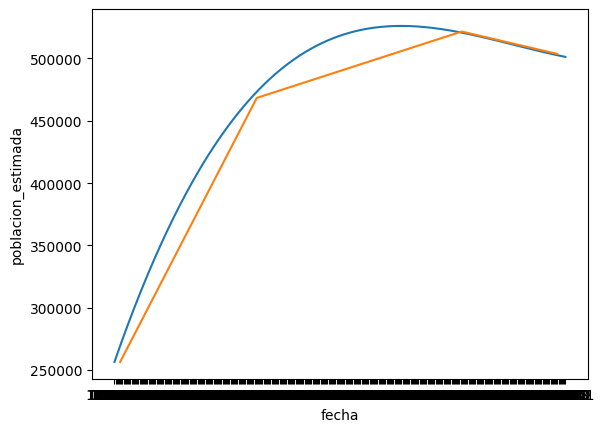

In [10]:
# Plot the data
comuna = 'MAIPU'
sns.lineplot(data=df_result[df_result['comuna'] == comuna], x='fecha', y='poblacion_estimada')
sns.lineplot(data=aux_comp[aux_comp["Comuna"] == comuna], x='anio', y='poblacion')

plt.show()

In [13]:
df_result.to_excel('poblacion_estimada.xlsx', index=False)

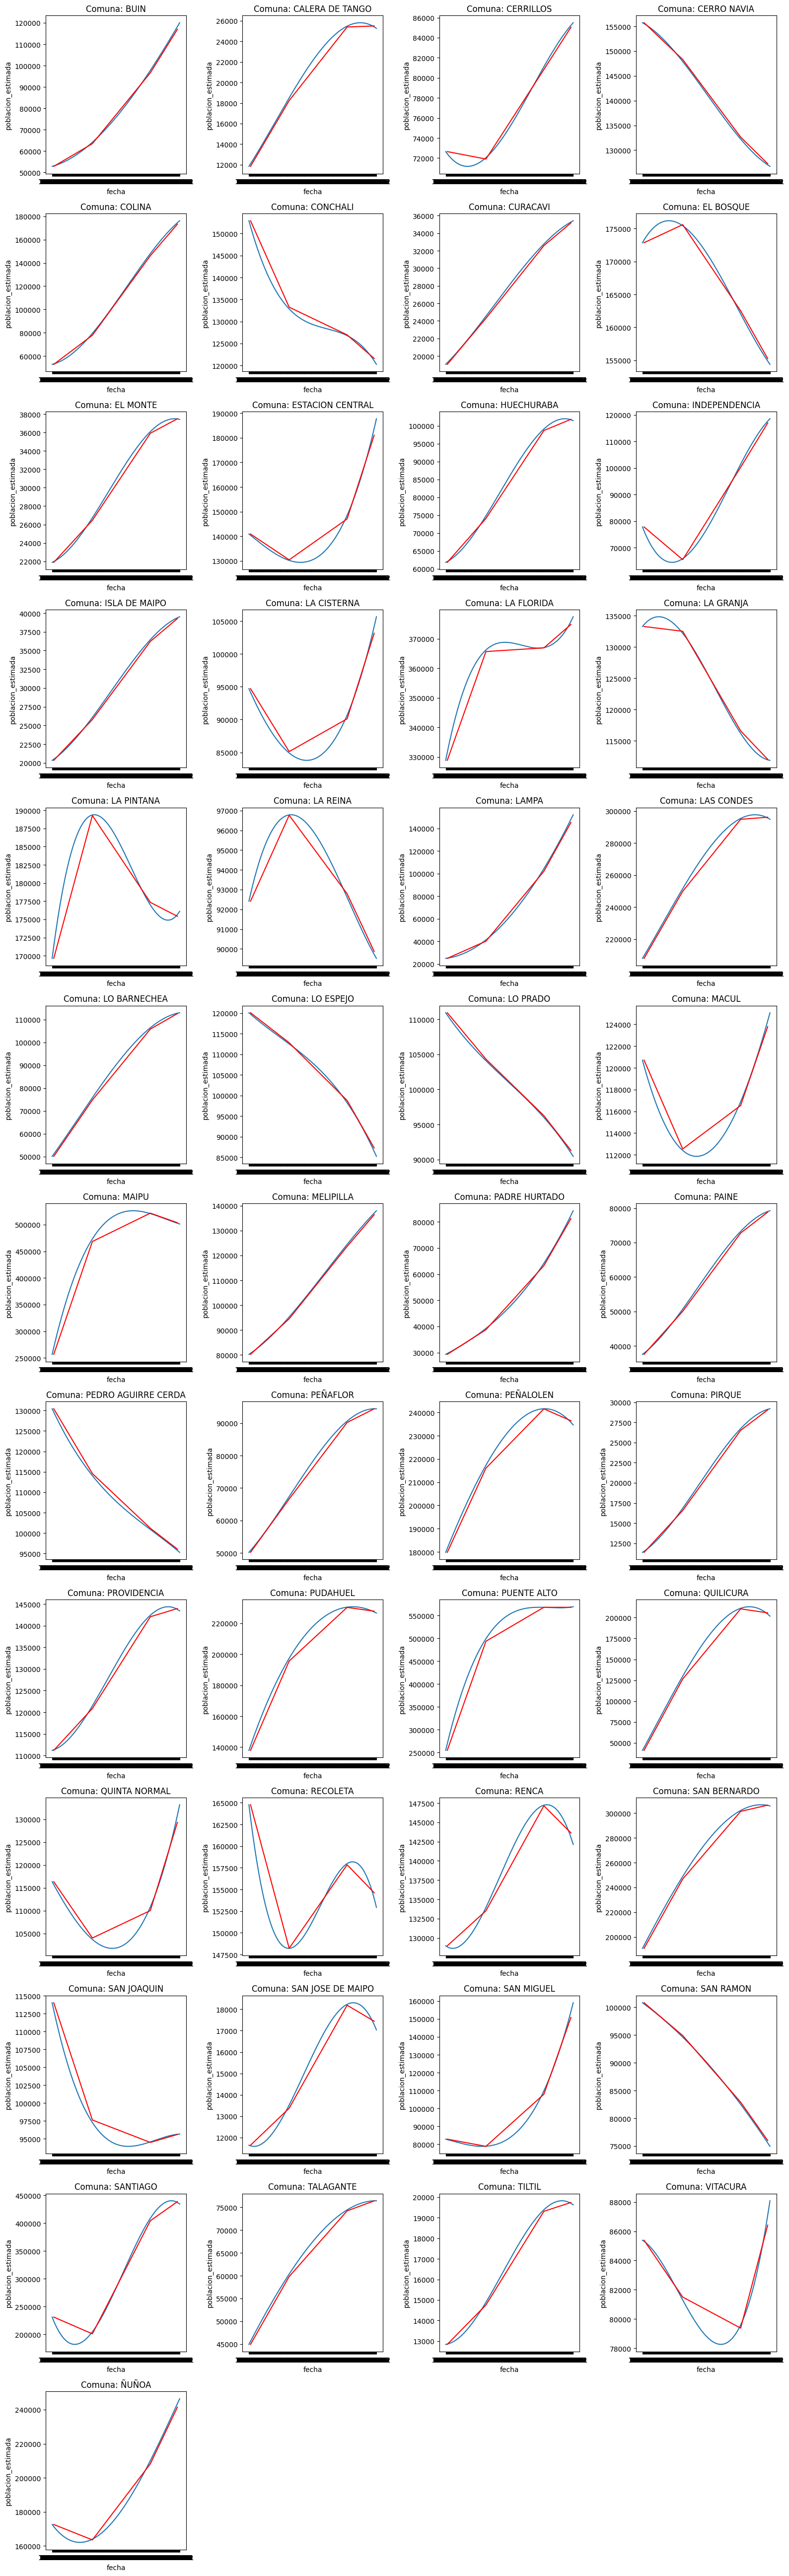

In [12]:
# Obtener las comunas únicas
comunas = df_result['comuna'].unique()

# Definir el número de gráficos por fila
graficos_por_fila = 4

# Calcular el número de filas necesarias
num_filas = -(-len(comunas) // graficos_por_fila)  # División redondeada hacia arriba

# Crear una figura con subgráficos
fig, axes = plt.subplots(num_filas, graficos_por_fila, figsize=(16, 4 * num_filas))
axes = axes.flatten()  # Convertir a una lista plana para iterar fácilmente

# Iterar sobre las comunas y los ejes
for i, (comuna, ax) in enumerate(zip(comunas, axes)):

    # Graficar la serie de tiempo
    sns.lineplot(data=df_result[df_result['comuna'] == comuna], x='fecha', y='poblacion_estimada', ax=ax)
    sns.lineplot(data=aux_comp[aux_comp["Comuna"] == comuna], x='anio', y='poblacion', ax=ax, color='red')
    ax.set_title(f"Comuna: {comuna}")
    

# Ocultar los ejes no utilizados si hay más subgráficos que comunas
for ax in axes[len(comunas):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

# Proyección de clientes

## Censo interpolado

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

In [3]:
df_proyecciones_ine = pd.read_excel('estimaciones-y-proyecciones-2002-2035.xlsx', sheet_name='EEPP comuna área')

In [4]:
# Filtrar solo las filas de la Región Metropolitana
df_filtrado = df_proyecciones_ine[df_proyecciones_ine['Nombre Region'] == 'Metropolitana de Santiago']

# Seleccionar únicamente 'Nombre Comuna' y columnas de población
columnas_poblacion = ['Nombre Comuna'] + [col for col in df_proyecciones_ine.columns if col.startswith('Poblacion')]
df_filtrado = df_filtrado[columnas_poblacion]

# Agrupar por 'Nombre Comuna' y sumar las columnas de población
df_agrupado = df_filtrado.groupby('Nombre Comuna', as_index=False).sum()

In [5]:
# Formatear datos anuales a largo
df_anual = df_agrupado.melt(id_vars='Nombre Comuna',
                            var_name='Año',
                            value_name='Poblacion')
df_anual['Año'] = df_anual['Año'].str.extract(r'(\d+)').astype(int)

# Generar un índice mensual para cada comuna
df_mensual_interp = pd.DataFrame()

for comuna in df_anual['Nombre Comuna'].unique():
    datos_comuna = df_anual[df_anual['Nombre Comuna'] == comuna].copy()

    # Crear índice temporal con fecha el 1ro de enero de cada año
    datos_comuna['Fecha'] = pd.to_datetime(dict(year=datos_comuna['Año'], month=1, day=1))
    datos_comuna = datos_comuna.set_index('Fecha').sort_index()

    # Reindexar a frecuencia mensual
    fechas_mensuales = pd.date_range(start=datos_comuna.index.min(), 
                                     end=datos_comuna.index.max() + pd.DateOffset(years=1) - pd.DateOffset(months=1),
                                     freq='MS')
    datos_mensual = datos_comuna.reindex(fechas_mensuales)
    datos_mensual['Nombre Comuna'] = comuna

    # Interpolación lineal mensual
    datos_mensual['Poblacion'] = datos_mensual['Poblacion'].interpolate(method='linear')

    # Guardar resultados
    datos_mensual = datos_mensual.reset_index().rename(columns={'index': 'Fecha'})
    datos_mensual['Año'] = datos_mensual['Fecha'].dt.year
    datos_mensual['Mes'] = datos_mensual['Fecha'].dt.month
    df_mensual_interp = pd.concat([df_mensual_interp, datos_mensual], ignore_index=True)


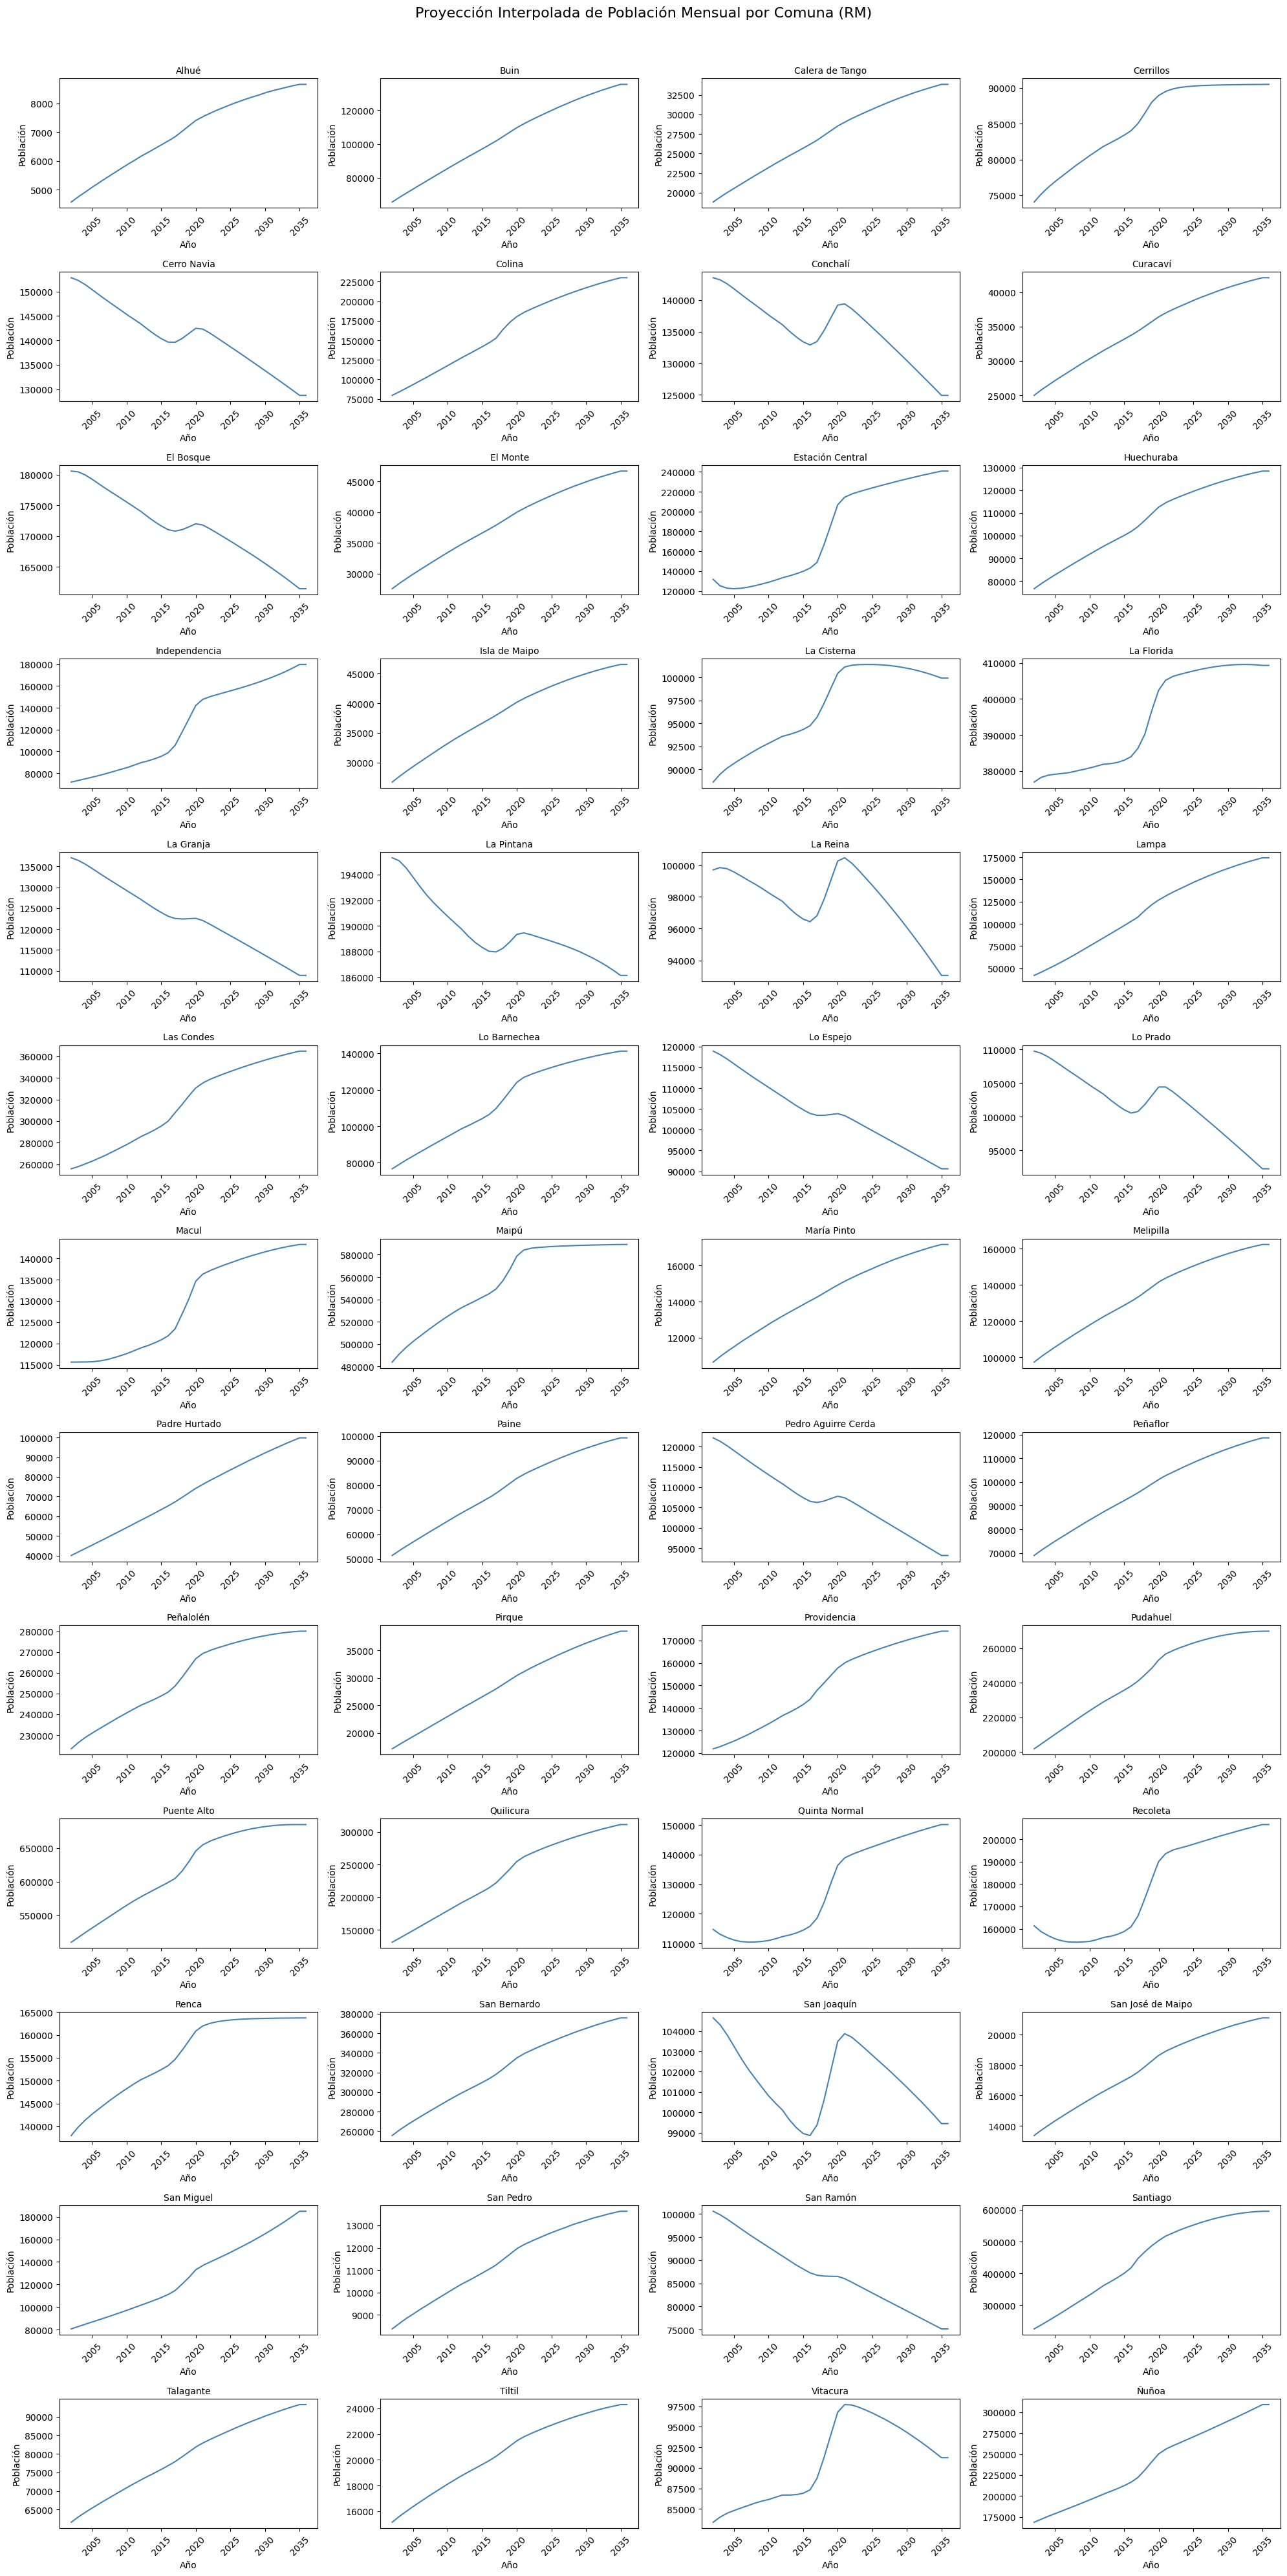

In [6]:
# Lista de comunas ordenadas
comunas = sorted(df_mensual_interp['Nombre Comuna'].unique())

# Parámetros de la grilla
n_comunas = len(comunas)
n_cols = 4
n_rows = (n_comunas + n_cols - 1) // n_cols

# Figura
plt.figure(figsize=(n_cols * 5, n_rows * 3))

for i, comuna in enumerate(comunas):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    datos = df_mensual_interp[df_mensual_interp['Nombre Comuna'] == comuna]
    ax.plot(datos['Fecha'], datos['Poblacion'], color='steelblue')
    ax.set_title(comuna, fontsize=10)
    ax.set_xlabel('Año')
    ax.set_ylabel('Población')

    # Mostrar solo cada 5 años
    ax.xaxis.set_major_locator(mdates.YearLocator(5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=45)

# Ajustes finales
plt.tight_layout()
plt.suptitle("Proyección Interpolada de Población Mensual por Comuna (RM)", fontsize=16, y=1.02)
plt.show()

In [6]:
df_mensual_interp

Fecha Nombre Comuna   Año      Poblacion  Mes
0     2002-01-01         Alhué  2002    4567.000000    1
1     2002-02-01         Alhué  2002    4581.833333    2
2     2002-03-01         Alhué  2002    4596.666667    3
3     2002-04-01         Alhué  2002    4611.500000    4
4     2002-05-01         Alhué  2002    4626.333333    5
...          ...           ...   ...            ...  ...
21211 2035-08-01         Ñuñoa  2035  309128.000000    8
21212 2035-09-01         Ñuñoa  2035  309128.000000    9
21213 2035-10-01         Ñuñoa  2035  309128.000000   10
21214 2035-11-01         Ñuñoa  2035  309128.000000   11
21215 2035-12-01         Ñuñoa  2035  309128.000000   12

[21216 rows x 5 columns]

In [7]:
df_mensual_interp[(df_mensual_interp['Nombre Comuna'] == 'Paine') & (df_mensual_interp['Mes'] == 12)][['Año', 'Poblacion']]

Año     Poblacion
11843  2002  53187.083333
11855  2003  55003.333333
11867  2004  56746.250000
11879  2005  58460.333333
11891  2006  60175.083333
11903  2007  61886.416667
11915  2008  63586.416667
11927  2009  65258.833333
11939  2010  66911.416667
11951  2011  68545.916667
11963  2012  70098.250000
11975  2013  71631.333333
11987  2014  73189.000000
11999  2015  74768.250000
12011  2016  76512.416667
12023  2017  78484.083333
12035  2018  80539.250000
12047  2019  82594.750000
12059  2020  84244.583333
12071  2021  85644.000000
12083  2022  86950.666667
12095  2023  88212.166667
12107  2024  89440.833333
12119  2025  90630.166667
12131  2026  91762.083333
12143  2027  92860.666667
12155  2028  93914.500000
12167  2029  94913.166667
12179  2030  95861.333333
12191  2031  96766.833333
12203  2032  97623.916667
12215  2033  98422.833333
12227  2034  99170.083333
12239  2035  99232.000000

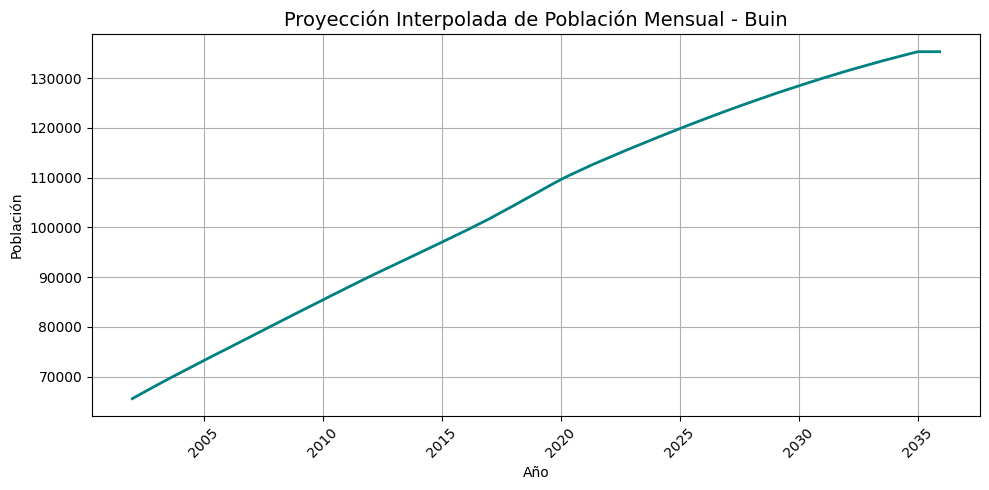

In [8]:
# Filtrar la comuna de Buin
df_buin_ine = df_mensual_interp[df_mensual_interp['Nombre Comuna'] == 'Buin']

# Crear la figura
plt.figure(figsize=(10, 5))
plt.plot(df_buin_ine['Fecha'], df_buin_ine['Poblacion'], color='teal', linewidth=2)

# Títulos y formato
plt.title("Proyección Interpolada de Población Mensual - Buin", fontsize=14)
plt.xlabel("Año")
plt.ylabel("Población")

# Mostrar cada 5 años en el eje x
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.grid(True)
plt.show()

## Histórico clientes y proyección

In [2]:
import pandas as pd

hacer una proyección por cada combinación comuna-localidad y comparar luego con las proyecciones del INE

In [10]:
df_agua = pd.read_csv('G:\OneDrive - usach.cl\Memoria\Código\Resultados CSV\df_agua.csv')

<>:1: SyntaxWarning: invalid escape sequence '\O'
<>:1: SyntaxWarning: invalid escape sequence '\O'
C:\Users\IanLagreze\AppData\Local\Temp\ipykernel_29732\3734516374.py:1: SyntaxWarning: invalid escape sequence '\O'
  df_agua = pd.read_csv('G:\OneDrive - usach.cl\Memoria\Código\Resultados CSV\df_agua.csv')


In [11]:
df_agua.head()

Fecha          Nombre Corto             Localidad       Comuna  \
0  2012-01-01  SANTA ROSA DEL PERAL  SANTA ROSA DEL PERAL  PUENTE ALTO   
1  2012-02-01  SANTA ROSA DEL PERAL  SANTA ROSA DEL PERAL  PUENTE ALTO   
2  2012-03-01  SANTA ROSA DEL PERAL  SANTA ROSA DEL PERAL  PUENTE ALTO   
3  2012-04-01  SANTA ROSA DEL PERAL  SANTA ROSA DEL PERAL  PUENTE ALTO   
4  2012-05-01  SANTA ROSA DEL PERAL  SANTA ROSA DEL PERAL  PUENTE ALTO   

  Tipo Cliente    M3 Ap  Clientes  Cargo fijo  Tarifa sobreconsumo  \
0  Residencial  16935.0     362.0      1186.0              1312.89   
1  Residencial  14895.0     362.0      1186.0              1312.89   
2  Residencial  14144.0     362.0      1186.0              1312.89   
3  Residencial  12434.0     362.0      1186.0              1312.89   
4  Residencial   9478.0     362.0      1186.0              1312.89   

   Periodo Punta  ...  IPC   Año  Mes  Dias Laborales  Dias No Laborales  \
0              1  ...  0.1  2012    1              23                  8   
1              1  ...  0.4  2012    2              22                  7   
2              1  ...  0.2  2012    3              22                  9   
3              0  ...  0.1  2012    4              18                 12   
4              0  ...  0.0  2012    5              22                  9   

       Poblacion    Tipo  Rios y Pozos  Caudales  Estacion  
0  564573.692886  Urbana           1.0     81.73    Verano  
1  564738.137573  Urbana           1.0     80.81    Verano  
2  564897.889618  Urbana           1.0     73.61    Verano  
3  565053.006866  Urbana           1.0     55.18     Otoño  
4  565203.547073  Urbana           1.0     53.64     Otoño  

[5 rows x 31 columns]

In [12]:
df_agua = df_agua[['Fecha', 'Nombre Corto', 'Localidad', 'Comuna', 'Tipo Cliente','M3 Ap', 'Clientes']]

In [13]:
# Asegurar que la columna Fecha esté en formato datetime
df_agua['Fecha'] = pd.to_datetime(df_agua['Fecha'], errors='coerce')

# Normalizar 'Grupo Cliente': dejar 'Residencial' y todo lo demás como 'No Residencial'
df_agua['Grupo Cliente'] = df_agua['Tipo Cliente'].apply(lambda x: 'Residencial' if x.upper() == 'RESIDENCIAL' else 'No Residencial')

# Agrupar por combinación única y tipo de cliente
df_agua = df_agua.groupby(['Fecha', 'Nombre Corto', 'Localidad', 'Comuna', 'Grupo Cliente'], as_index=False)[['M3 Ap', 'Clientes']].sum()

# Extraer el año
df_agua['Año'] = df_agua['Fecha'].dt.year

# Agrupar por año, Nombre Corto, Localidad, Comuna y Grupo Cliente
df_anual = df_agua.groupby(['Año', 'Nombre Corto', 'Localidad', 'Comuna', 'Grupo Cliente'], as_index=False )[['M3 Ap', 'Clientes']].sum()

df_anual_2024 = df_anual[df_anual['Año'] == 2024].copy()

In [14]:
# Paso 1: Separar residencial y no residencial
residencial = df_anual_2024[df_anual_2024['Grupo Cliente'] == 'Residencial']
no_residencial = df_anual_2024[df_anual_2024['Grupo Cliente'] != 'Residencial']

# Paso 2: Renombrar columnas para merge posterior
residencial = residencial.rename(columns={'M3 Ap': 'M3_Res'})
no_residencial = no_residencial.rename(columns={'M3 Ap': 'M3_NoRes'})

# Paso 3: Unir por Nombre Corto + Localidad + Comuna
df_proporcion = pd.merge(
    residencial[['Nombre Corto', 'Localidad', 'Comuna', 'M3_Res']],
    no_residencial[['Nombre Corto', 'Localidad', 'Comuna', 'M3_NoRes']],
    on=['Nombre Corto', 'Localidad', 'Comuna'],
    how='outer'
).fillna(0)

# Paso 4: Calcular proporción no residencial
df_proporcion['Proporcion_NoRes'] = df_proporcion['M3_NoRes'] / (df_proporcion['M3_Res'] + df_proporcion['M3_NoRes'])

# Paso 5: Aplicar regla de decisión
# Por defecto: no_desagregar = 1 si proporción < 20%
df_proporcion['no_desagregar'] = (df_proporcion['Proporcion_NoRes'] < 0.2).astype(int)

# Paso 6 (opcional): marcar casos justificados manualmente
# Por ejemplo, si quieres forzar el uso agregado en ciertos casos:
casos_justificados = [
    # ('Nombre Corto', 'Localidad', 'Comuna'),
    # ('AGUAS ANDINAS', 'BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL', 'BUIN'),
]
df_proporcion.loc[
    df_proporcion.set_index(['Nombre Corto', 'Localidad', 'Comuna']).index.isin(casos_justificados),
    'no_desagregar'
] = 1

In [16]:
df_proporcion

Nombre Corto                                      Localidad  \
0    AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
1    AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
2    AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
3    AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
4    AGUAS ANDINAS                                CALERA DE TANGO   
..             ...                                            ...   
152          SMAPA                                          MAIPU   
153          SMAPA                                          MAIPU   
154          SMAPA                                          MAIPU   
155          SMAPA                                          MAIPU   
156          SMAPA                                          MAIPU   

               Comuna        M3_Res      M3_NoRes  Proporcion_NoRes  \
0                BUIN  6.040402e+06  1.764090e+06          0.226035   
1           MELIPILLA  0.000000e+00  0.000000e+00               NaN   
2               PAINE  2.363172e+06  8.175169e+05          0.257025   
3           TALAGANTE  2.630000e+02  1.790000e+02          0.404977   
4     CALERA DE TANGO  1.212690e+06  5.524656e+05          0.312984   
..                ...           ...           ...               ...   
152         CERRILLOS  4.956275e+06  3.674231e+06          0.425726   
153  ESTACION CENTRAL  3.086832e+06  7.994439e+05          0.205710   
154        LAS CONDES  0.000000e+00  3.690000e+02          1.000000   
155             MAIPU  3.103418e+07  5.395542e+06          0.148108   
156          SANTIAGO  0.000000e+00  0.000000e+00               NaN   

     no_desagregar  
0                0  
1                0  
2                0  
3                0  
4                0  
..             ...  
152              0  
153              0  
154              0  
155              1  
156              0  

[157 rows x 7 columns]

In [17]:
# Paso 1: Crear una copia para trabajar con seguridad
df_agua_mod = df_agua.copy()

# Paso 2: Identificar combinaciones con no_desagregar == 1
combinaciones_agregadas = df_proporcion[df_proporcion['no_desagregar'] == 1][
    ['Nombre Corto', 'Localidad', 'Comuna']
]

# Paso 3: Marcar en df_agua las filas que deben agregarse
df_agua_mod['Agrupar'] = df_agua_mod.merge(
    combinaciones_agregadas.assign(Agrupar=True),
    on=['Nombre Corto', 'Localidad', 'Comuna'],
    how='left'
)['Agrupar'].fillna(False)

# Paso 4: Reemplazar "Grupo Cliente" por "Total" donde corresponde
df_agua_mod.loc[df_agua_mod['Agrupar'], 'Grupo Cliente'] = 'Total'

# Paso 5: Agrupar sumando M3 Ap y Clientes
df_agua_final = df_agua_mod.groupby(
    ['Fecha', 'Nombre Corto', 'Localidad', 'Comuna', 'Grupo Cliente'],
    as_index=False
)[['M3 Ap', 'Clientes']].sum()

C:\Users\IanLagreze\AppData\Local\Temp\ipykernel_29732\2545069295.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  )['Agrupar'].fillna(False)


In [18]:
df_agua_final.loc[df_agua_final["Grupo Cliente"] == "Total", "Grupo Cliente"] = "Residencial"

In [20]:
df_agua_final[["Localidad", "Grupo Cliente"]].value_counts()


Localidad                 Grupo Cliente 
GRAN SANTIAGO             Residencial       5792
                          No Residencial    3982
EL MONTE - EL PAICO       Residencial       1376
                          No Residencial     752
SANTA MARIA DE MANQUEHUE  No Residencial     539
                                            ... 
REINA NORTE               Residencial         46
                          No Residencial      46
VALLE GRANDE              No Residencial      46
CHICUREO                  No Residencial      42
ISLA DE MAIPO             No Residencial      36
Name: count, Length: 93, dtype: int64

In [16]:
# Fechas objetivo
fechas_futuras = pd.date_range(start='2025-01-01', end='2030-12-01', freq='MS')
n_periods = len(fechas_futuras)

# Función para elegir el mejor modelo
def forecast_best_model(serie, n_periods):
    serie = serie.dropna()
    if len(serie) < 2:
        return np.full(n_periods, np.nan)

    preds = {}

    # Regresión lineal
    try:
        X = np.arange(len(serie)).reshape(-1, 1)
        y = serie.values
        model = LinearRegression().fit(X, y)
        X_pred = np.arange(len(serie), len(serie) + n_periods).reshape(-1, 1)
        preds['regresion'] = model.predict(X_pred)
    except:
        preds['regresion'] = np.full(n_periods, np.nan)

    # Interpolación lineal extendida
    try:
        last_value = serie.iloc[-1]
        slope = (serie.iloc[-1] - serie.iloc[0]) / (len(serie) - 1) if len(serie) > 1 else 0
        preds['interpolacion'] = last_value + slope * np.arange(1, n_periods + 1)
    except:
        preds['interpolacion'] = np.full(n_periods, np.nan)

    # ARIMA
    try:
        arima_model = ARIMA(serie, order=(1, 1, 1)).fit()
        preds['arima'] = arima_model.forecast(steps=n_periods).values
    except:
        preds['arima'] = np.full(n_periods, np.nan)

    # Evaluación con RMSE si hay suficientes datos
    if len(serie) >= 12:
        test = serie[-12:]
        train = serie[:-12]
        rmse_scores = {}
        for key in preds:
            pred = preds[key][:12]
            if not np.isnan(pred).all():
                rmse = mean_squared_error(test, pred, squared=False)
            else:
                rmse = np.inf
            rmse_scores[key] = rmse
        best_model = min(rmse_scores, key=rmse_scores.get)
    else:
        best_model = 'regresion' if not np.isnan(preds['regresion']).all() else 'interpolacion'

    return preds[best_model]

# Crear lista para almacenar resultados
proyecciones = []

# Agrupar por combinación única
grupos = df_agua_final.groupby(['Nombre Corto', 'Localidad', 'Comuna', 'Grupo Cliente'])

for (nombre_corto, localidad, comuna, grupo), grupo_df in grupos:
    grupo_df = grupo_df.sort_values('Fecha')
    
    # Series históricas
    clientes_hist = grupo_df.set_index('Fecha')['Clientes']
    m3_hist = grupo_df.set_index('Fecha')['M3 Ap']

    # Proyecciones
    clientes_pred = forecast_best_model(clientes_hist, n_periods)
    m3_pred = forecast_best_model(m3_hist, n_periods)

    # Armar DataFrame con mismo formato
    df_pred = pd.DataFrame({
        'Fecha': fechas_futuras,
        'Nombre Corto': nombre_corto,
        'Localidad': localidad,
        'Comuna': comuna,
        'Grupo Cliente': grupo,
        'Clientes': clientes_pred,
        'M3 Ap': m3_pred
    })

    proyecciones.append(df_pred)

# Concatenar resultados
df_proyecciones = pd.concat(proyecciones, ignore_index=True)



C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\l

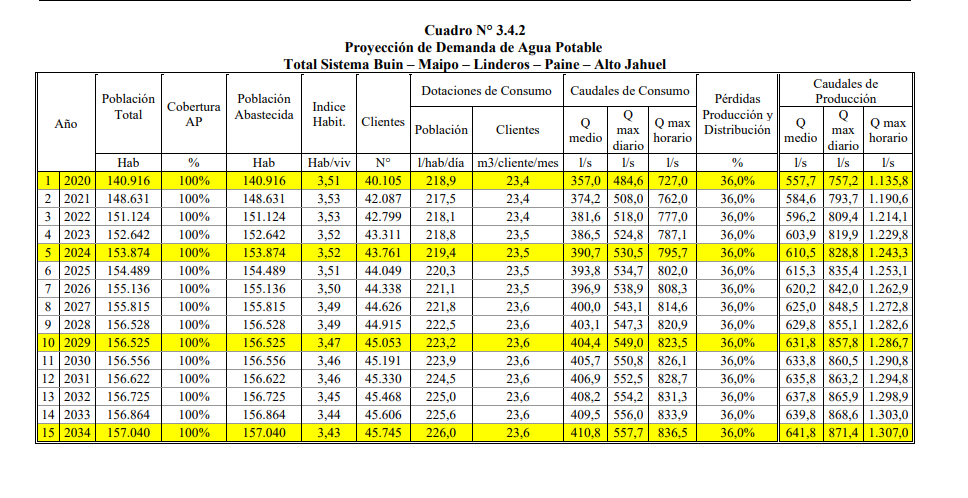

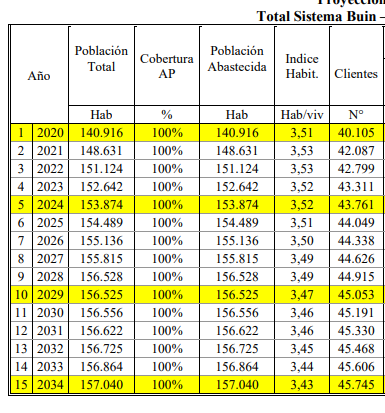

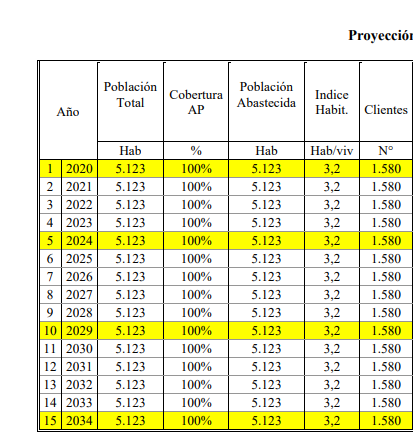

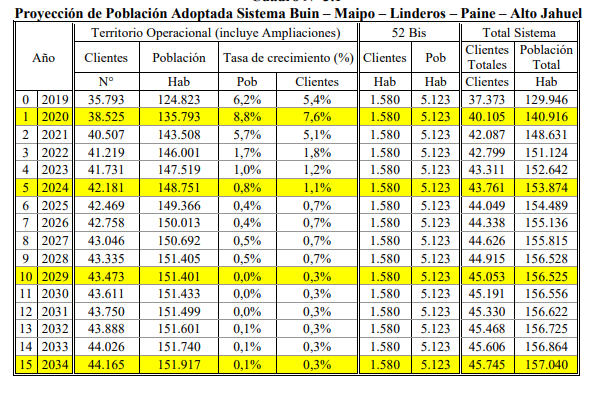

In [92]:
df_proyecciones.columns

Index(['Fecha', 'Nombre Corto', 'Localidad', 'Comuna', 'Grupo Cliente',
       'Clientes', 'M3 Ap'],
      dtype='object')

In [18]:
df_proyecciones[
    (df_proyecciones['Nombre Corto'] == 'AGUAS ANDINAS') &
    (df_proyecciones['Localidad'] == 'BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL') &
    (df_proyecciones['Fecha'].dt.month == 1)
].groupby('Fecha', as_index=False)['Clientes'].sum()

Fecha      Clientes
0 2025-01-01  41903.211405
1 2026-01-01  42086.991537
2 2027-01-01  42185.694003
3 2028-01-01  42241.113778
4 2029-01-01  42274.442999
5 2030-01-01  42296.497474

In [19]:
df_agua_final[
    (df_agua_final['Nombre Corto'] == 'AGUAS ANDINAS') &
    (df_agua_final['Localidad'] == 'BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL') &
    (df_agua_final['Fecha'].dt.month == 1)
].groupby('Fecha', as_index=False)['Clientes'].sum()

Fecha  Clientes
0  2012-01-01   26377.0
1  2013-01-01   27178.0
2  2014-01-01   28245.0
3  2015-01-01   28640.0
4  2016-01-01   29043.0
5  2017-01-01   31252.0
6  2018-01-01   32900.0
7  2019-01-01   34278.0
8  2020-01-01   36523.0
9  2021-01-01   37793.0
10 2022-01-01   38603.0
11 2023-01-01   40634.0
12 2024-01-01   41719.0

In [20]:
df_agua_final.head()

Fecha   Nombre Corto                                      Localidad  \
0 2012-01-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
1 2012-01-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
2 2012-01-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
3 2012-01-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
4 2012-01-01  AGUAS ANDINAS                                CALERA DE TANGO   

            Comuna   Grupo Cliente      M3 Ap  Clientes  
0             BUIN  No Residencial  149980.55    1110.0  
1             BUIN     Residencial  406371.24   16337.0  
2            PAINE  No Residencial   57303.35     484.0  
3            PAINE     Residencial  169485.26    8446.0  
4  CALERA DE TANGO  No Residencial   51454.45     268.0

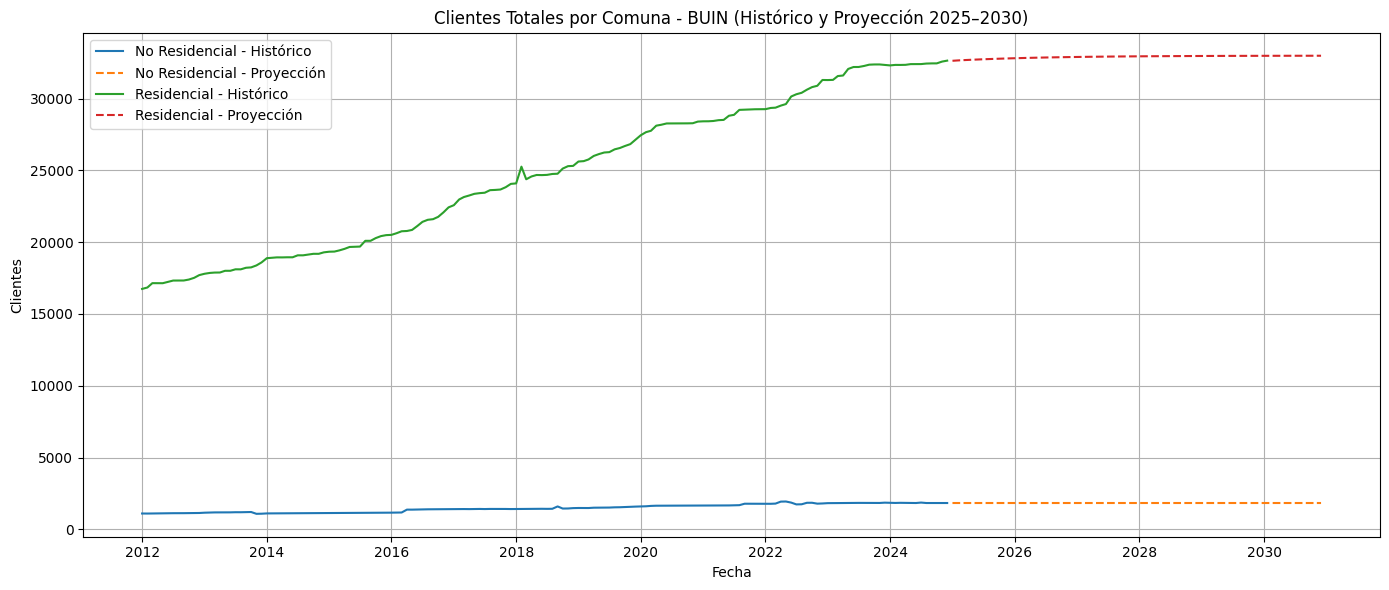

In [21]:
# Paso 1: Agrupar histórico y proyección por Fecha, Comuna, Grupo Cliente
hist_buin = (
    df_agua_final
    .groupby(['Fecha', 'Comuna', 'Grupo Cliente'], as_index=False)[['Clientes', 'M3 Ap']]
    .sum()
)

proj_buin = (
    df_proyecciones
    .groupby(['Fecha', 'Comuna', 'Grupo Cliente'], as_index=False)[['Clientes', 'M3 Ap']]
    .sum()
)

# Paso 2: Filtrar solo BUIN
hist_buin = hist_buin[hist_buin['Comuna'] == 'BUIN'].copy()
proj_buin = proj_buin[proj_buin['Comuna'] == 'BUIN'].copy()

# Paso 3: Marcar origen y concatenar
hist_buin['Origen'] = 'Histórico'
proj_buin['Origen'] = 'Proyección'
df_buin = pd.concat([hist_buin, proj_buin], ignore_index=True)

# Paso 4: Graficar por tipo de cliente
plt.figure(figsize=(14, 6))
for tipo in df_buin['Grupo Cliente'].unique():
    df_tipo = df_buin[df_buin['Grupo Cliente'] == tipo]
    df_hist = df_tipo[df_tipo['Origen'] == 'Histórico']
    df_proj = df_tipo[df_tipo['Origen'] == 'Proyección']

    plt.plot(df_hist['Fecha'], df_hist['Clientes'], label=f'{tipo} - Histórico', linestyle='-')
    plt.plot(df_proj['Fecha'], df_proj['Clientes'], label=f'{tipo} - Proyección', linestyle='--')

plt.title('Clientes Totales por Comuna - BUIN (Histórico y Proyección 2025–2030)')
plt.xlabel('Fecha')
plt.ylabel('Clientes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
df_buin.head()

Fecha Comuna   Grupo Cliente  Clientes      M3 Ap     Origen
0 2012-01-01   BUIN  No Residencial    1110.0  149980.55  Histórico
1 2012-01-01   BUIN     Residencial   16746.0  419526.24  Histórico
2 2012-02-01   BUIN  No Residencial    1107.0  132158.80  Histórico
3 2012-02-01   BUIN     Residencial   16844.0  397879.47  Histórico
4 2012-03-01   BUIN  No Residencial    1112.0  144611.71  Histórico

In [23]:
# Paso 1: Usar el DataFrame combinado de antes
df_buin_total = df_buin.copy()

# Paso 2: Agrupar por Fecha y Origen, sumando todos los tipos de cliente
df_buin_total_agrupado = (
    df_buin_total
    .groupby(['Fecha', 'Origen'], as_index=False)['Clientes']
    .sum()
)

In [24]:
df_buin_total[df_buin_total['Fecha'].dt.month == 1].groupby('Fecha', as_index=False)['Clientes'].sum()

Fecha      Clientes
0  2012-01-01  17856.000000
1  2013-01-01  18967.000000
2  2014-01-01  20002.000000
3  2015-01-01  20476.000000
4  2016-01-01  21678.000000
5  2017-01-01  23993.000000
6  2018-01-01  25516.000000
7  2019-01-01  27109.000000
8  2020-01-01  29041.000000
9  2021-01-01  30071.000000
10 2022-01-01  31048.000000
11 2023-01-01  33118.000000
12 2024-01-01  34161.000000
13 2025-01-01  34469.500028
14 2026-01-01  34647.202917
15 2027-01-01  34735.599856
16 2028-01-01  34780.714937
17 2029-01-01  34803.740292
18 2030-01-01  34815.491727

In [25]:
df_buin_total[df_buin_total['Fecha'].dt.month == 12].groupby('Fecha', as_index=False)['Clientes'].sum()


Fecha      Clientes
0  2012-12-01  18854.000000
1  2013-12-01  19687.000000
2  2014-12-01  20429.000000
3  2015-12-01  21653.000000
4  2016-12-01  23845.000000
5  2017-12-01  25479.000000
6  2018-12-01  26796.000000
7  2019-12-01  28718.000000
8  2020-12-01  30051.000000
9  2021-12-01  31048.000000
10 2022-12-01  33102.000000
11 2023-12-01  34208.000000
12 2024-12-01  34479.000000
13 2025-12-01  34636.794415
14 2026-12-01  34730.287692
15 2027-12-01  34778.003774
16 2028-12-01  34802.356598
17 2029-12-01  34814.785533
18 2030-12-01  34821.128879

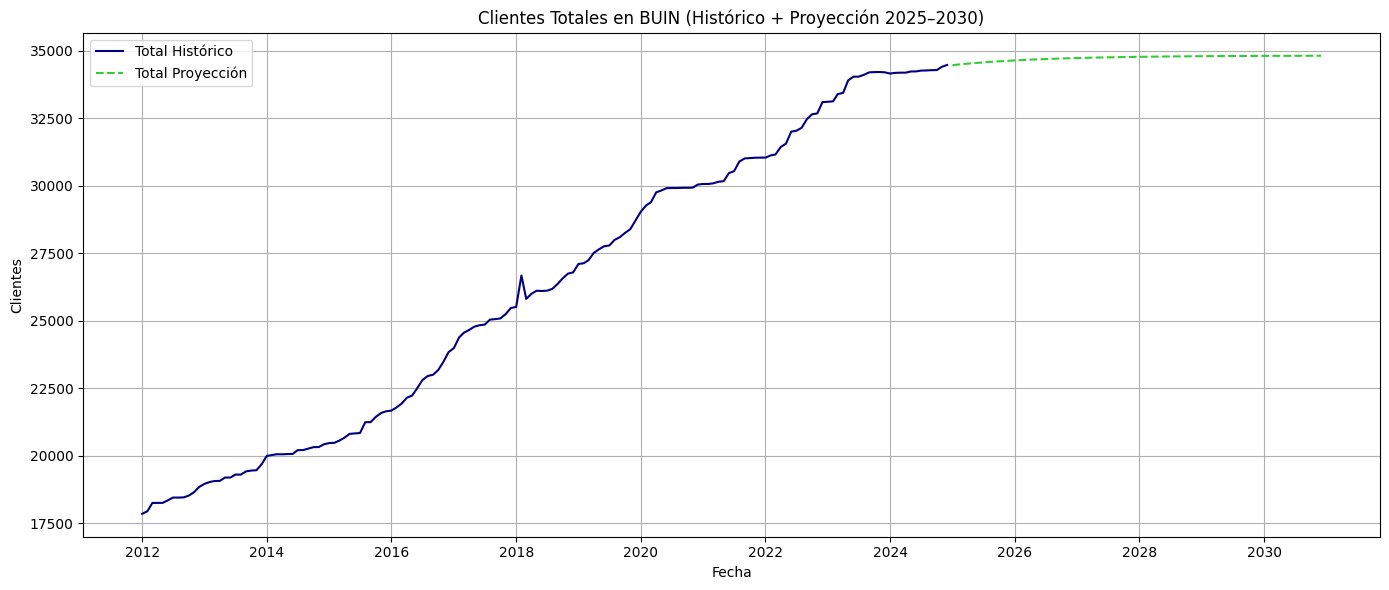

In [26]:
# Paso 3: Separar histórico y proyección
df_hist = df_buin_total_agrupado[df_buin_total_agrupado['Origen'] == 'Histórico']
df_proj = df_buin_total_agrupado[df_buin_total_agrupado['Origen'] == 'Proyección']

# Paso 4: Graficar
plt.figure(figsize=(14, 6))
plt.plot(df_hist['Fecha'], df_hist['Clientes'], label='Total Histórico', color='navy')
plt.plot(df_proj['Fecha'], df_proj['Clientes'], label='Total Proyección', color='limegreen', linestyle='--')

plt.title('Clientes Totales en BUIN (Histórico + Proyección 2025–2030)')
plt.xlabel('Fecha')
plt.ylabel('Clientes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


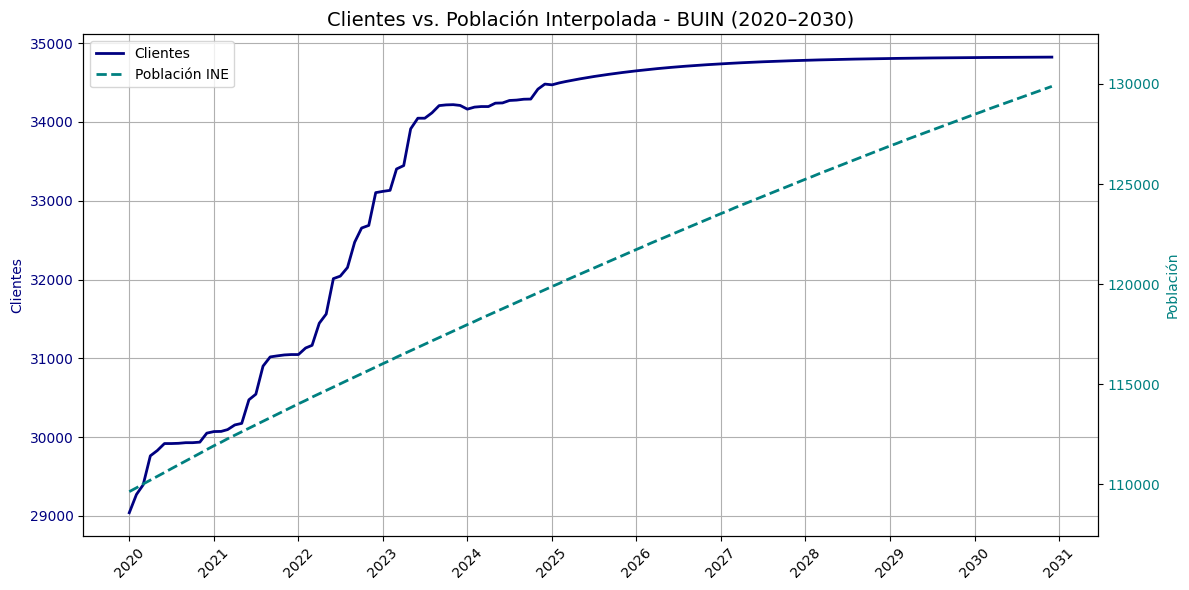

In [27]:
# Asegurar que las fechas estén en datetime
df_buin_ine['Fecha'] = pd.to_datetime(df_buin_ine['Fecha'])
df_buin_total['Fecha'] = pd.to_datetime(df_buin_total['Fecha'])

# Paso 1: Agrupar clientes por fecha (sumando todos los tipos de cliente)
clientes_totales = (
    df_buin_total
    .groupby('Fecha', as_index=False)['Clientes']
    .sum()
)

# Paso 2: Filtrar ambas series entre 2020 y 2030
clientes_filtrado = clientes_totales[
    (clientes_totales['Fecha'] >= '2020-01-01') & (clientes_totales['Fecha'] <= '2030-12-31')
]

poblacion_filtrada = df_buin_ine[
    (df_buin_ine['Fecha'] >= '2020-01-01') & (df_buin_ine['Fecha'] <= '2030-12-31')
]

# Paso 3: Crear figura y eje primario
fig, ax1 = plt.subplots(figsize=(12, 6))

# Curva de clientes (eje izquierdo)
ax1.plot(clientes_filtrado['Fecha'], clientes_filtrado['Clientes'], color='navy', linewidth=2, label='Clientes')
ax1.set_ylabel('Clientes', color='navy')
ax1.tick_params(axis='y', labelcolor='navy')

# Eje x: formato de fechas
ax1.xaxis.set_major_locator(mdates.YearLocator(1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# Paso 4: Crear eje secundario para población
ax2 = ax1.twinx()
ax2.plot(poblacion_filtrada['Fecha'], poblacion_filtrada['Poblacion'], color='teal', linewidth=2, linestyle='--', label='Población INE')
ax2.set_ylabel('Población', color='teal')
ax2.tick_params(axis='y', labelcolor='teal')

# Ajustar límites del eje Y de población si son válidos
pob_min = poblacion_filtrada['Poblacion'].min()
pob_max = poblacion_filtrada['Poblacion'].max()
if np.isfinite(pob_min) and np.isfinite(pob_max):
    ax2.set_ylim(pob_min * 0.98, pob_max * 1.02)

# Título y leyenda
plt.title("Clientes vs. Población Interpolada - BUIN (2020–2030)", fontsize=14)
fig.tight_layout()
ax1.grid(True)

# Combinar leyendas
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()



In [28]:
import unicodedata

# Función para quitar tildes y pasar a mayúsculas
def normalizar_comuna(nombre):
    nombre = unicodedata.normalize('NFKD', nombre).encode('ASCII', 'ignore').decode('utf-8')
    return nombre.upper()

# Aplicar transformación
df_mensual_interp['Nombre Comuna'] = df_mensual_interp['Nombre Comuna'].apply(normalizar_comuna)

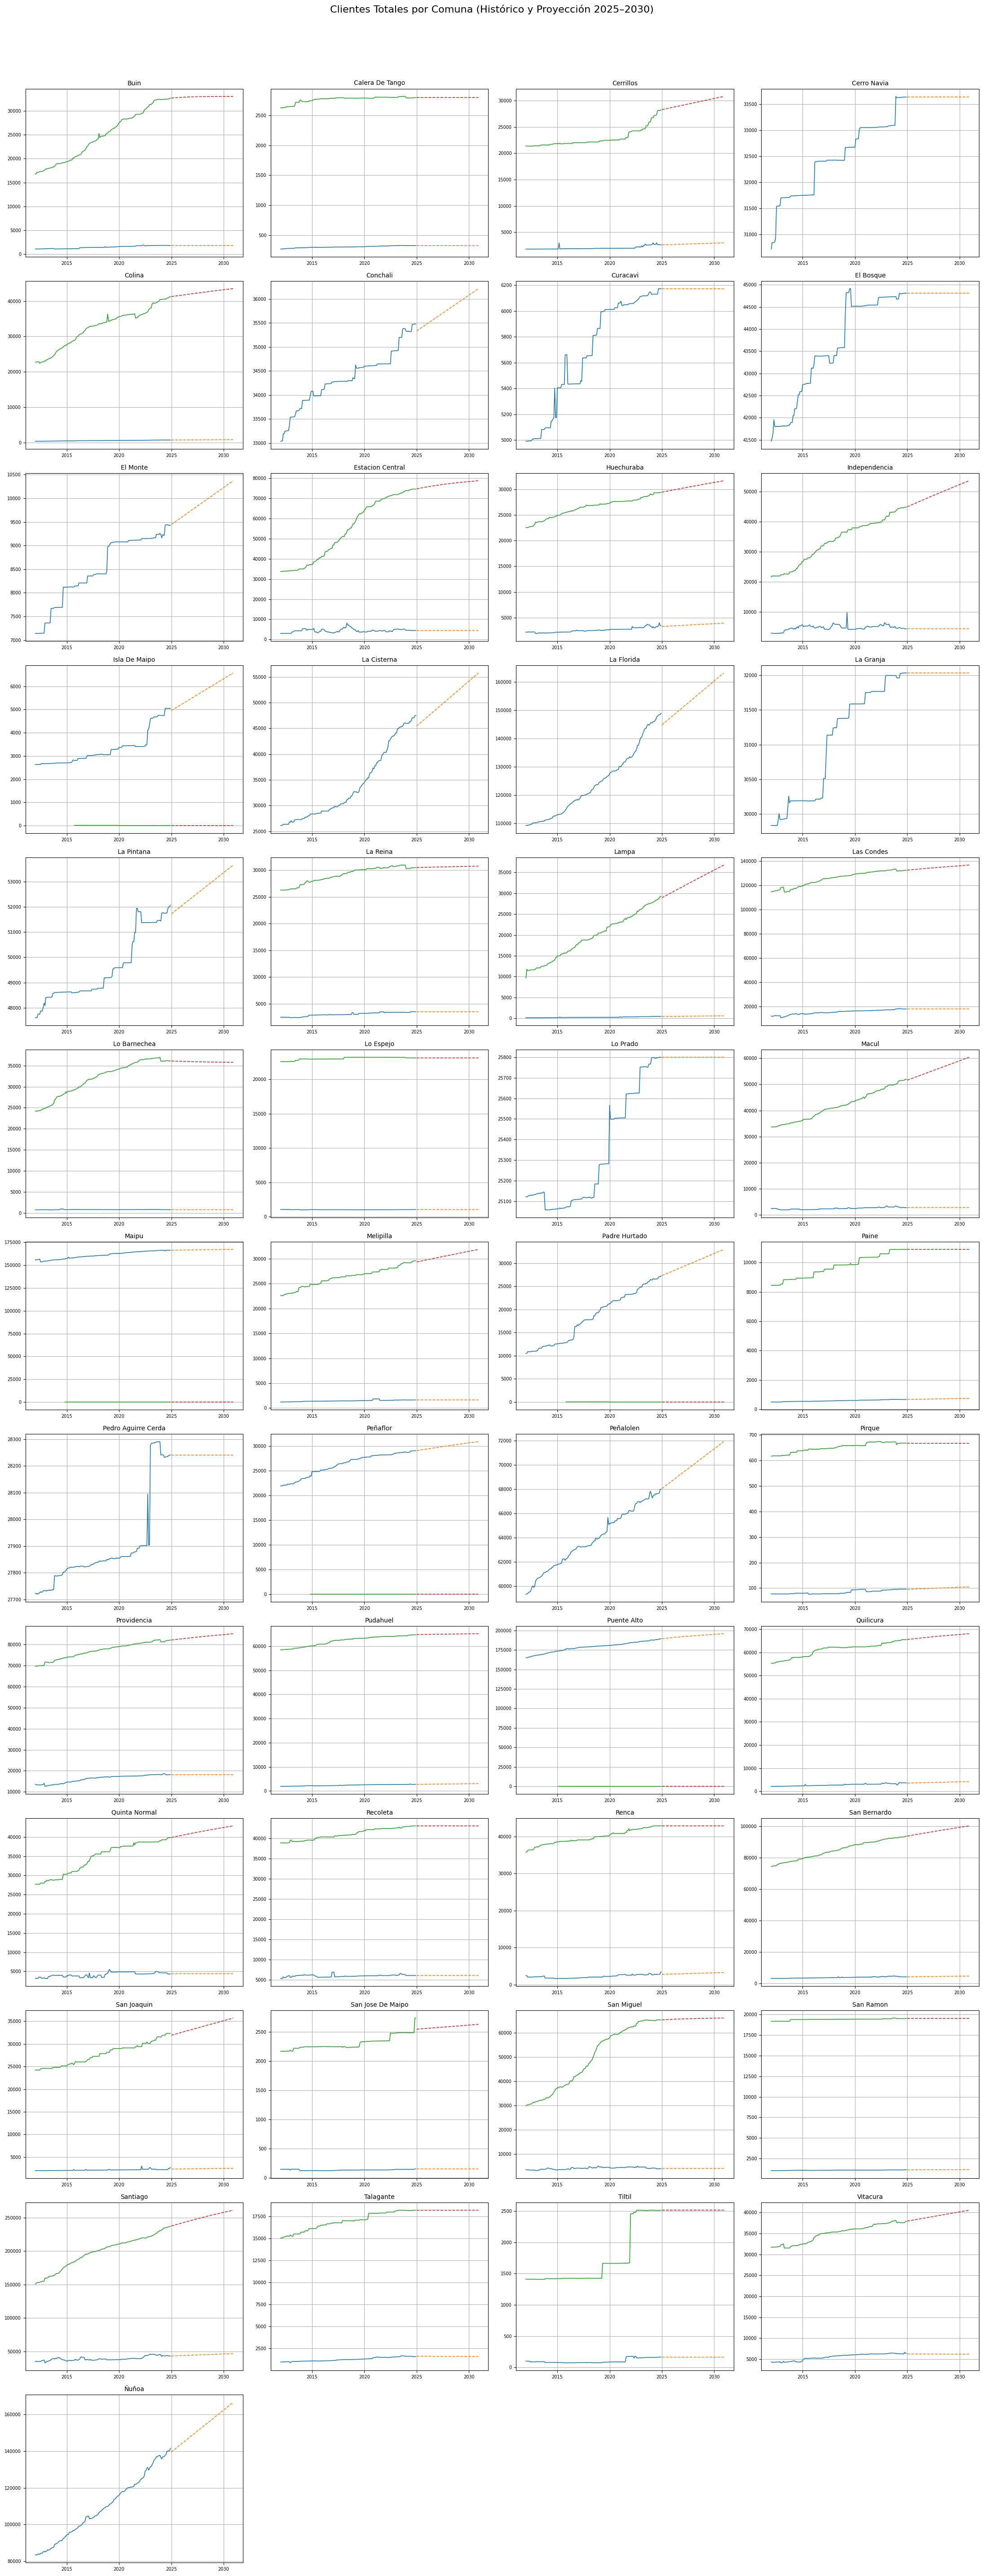

In [29]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Paso 1: Agrupar histórico y proyección por Fecha, Comuna, Grupo Cliente
hist_all = (
    df_agua_final
    .groupby(['Fecha', 'Comuna', 'Grupo Cliente'], as_index=False)[['Clientes', 'M3 Ap']]
    .sum()
)

proj_all = (
    df_proyecciones
    .groupby(['Fecha', 'Comuna', 'Grupo Cliente'], as_index=False)[['Clientes', 'M3 Ap']]
    .sum()
)

# Paso 2: Marcar origen
hist_all['Origen'] = 'Histórico'
proj_all['Origen'] = 'Proyección'

# Paso 3: Concatenar ambos
df_completo = pd.concat([hist_all, proj_all], ignore_index=True)

# Paso 4: Obtener comunas únicas
comunas = sorted(df_completo['Comuna'].unique())
n = len(comunas)
cols = 4
rows = int(np.ceil(n / cols))

# Paso 5: Crear figura con subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5.5, rows * 4.5), sharex=False)
axes = axes.flatten()

# Paso 6: Graficar por comuna
for i, comuna in enumerate(comunas):
    ax = axes[i]
    df_comuna = df_completo[df_completo['Comuna'] == comuna]

    for tipo in df_comuna['Grupo Cliente'].unique():
        df_tipo = df_comuna[df_comuna['Grupo Cliente'] == tipo]
        df_hist = df_tipo[df_tipo['Origen'] == 'Histórico']
        df_proj = df_tipo[df_tipo['Origen'] == 'Proyección']

        ax.plot(df_hist['Fecha'], df_hist['Clientes'], label=f'{tipo} - Hist.', linestyle='-', linewidth=1.2)
        ax.plot(df_proj['Fecha'], df_proj['Clientes'], label=f'{tipo} - Proy.', linestyle='--', linewidth=1.2)

    ax.set_title(comuna.title(), fontsize=10)
    ax.tick_params(axis='x', labelsize=7)
    ax.tick_params(axis='y', labelsize=7)
    ax.xaxis.set_major_locator(mdates.YearLocator(5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.grid(True)

# Paso 7: Ocultar ejes vacíos
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Paso 8: Ajustes finales
plt.suptitle("Clientes Totales por Comuna (Histórico y Proyección 2025–2030)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


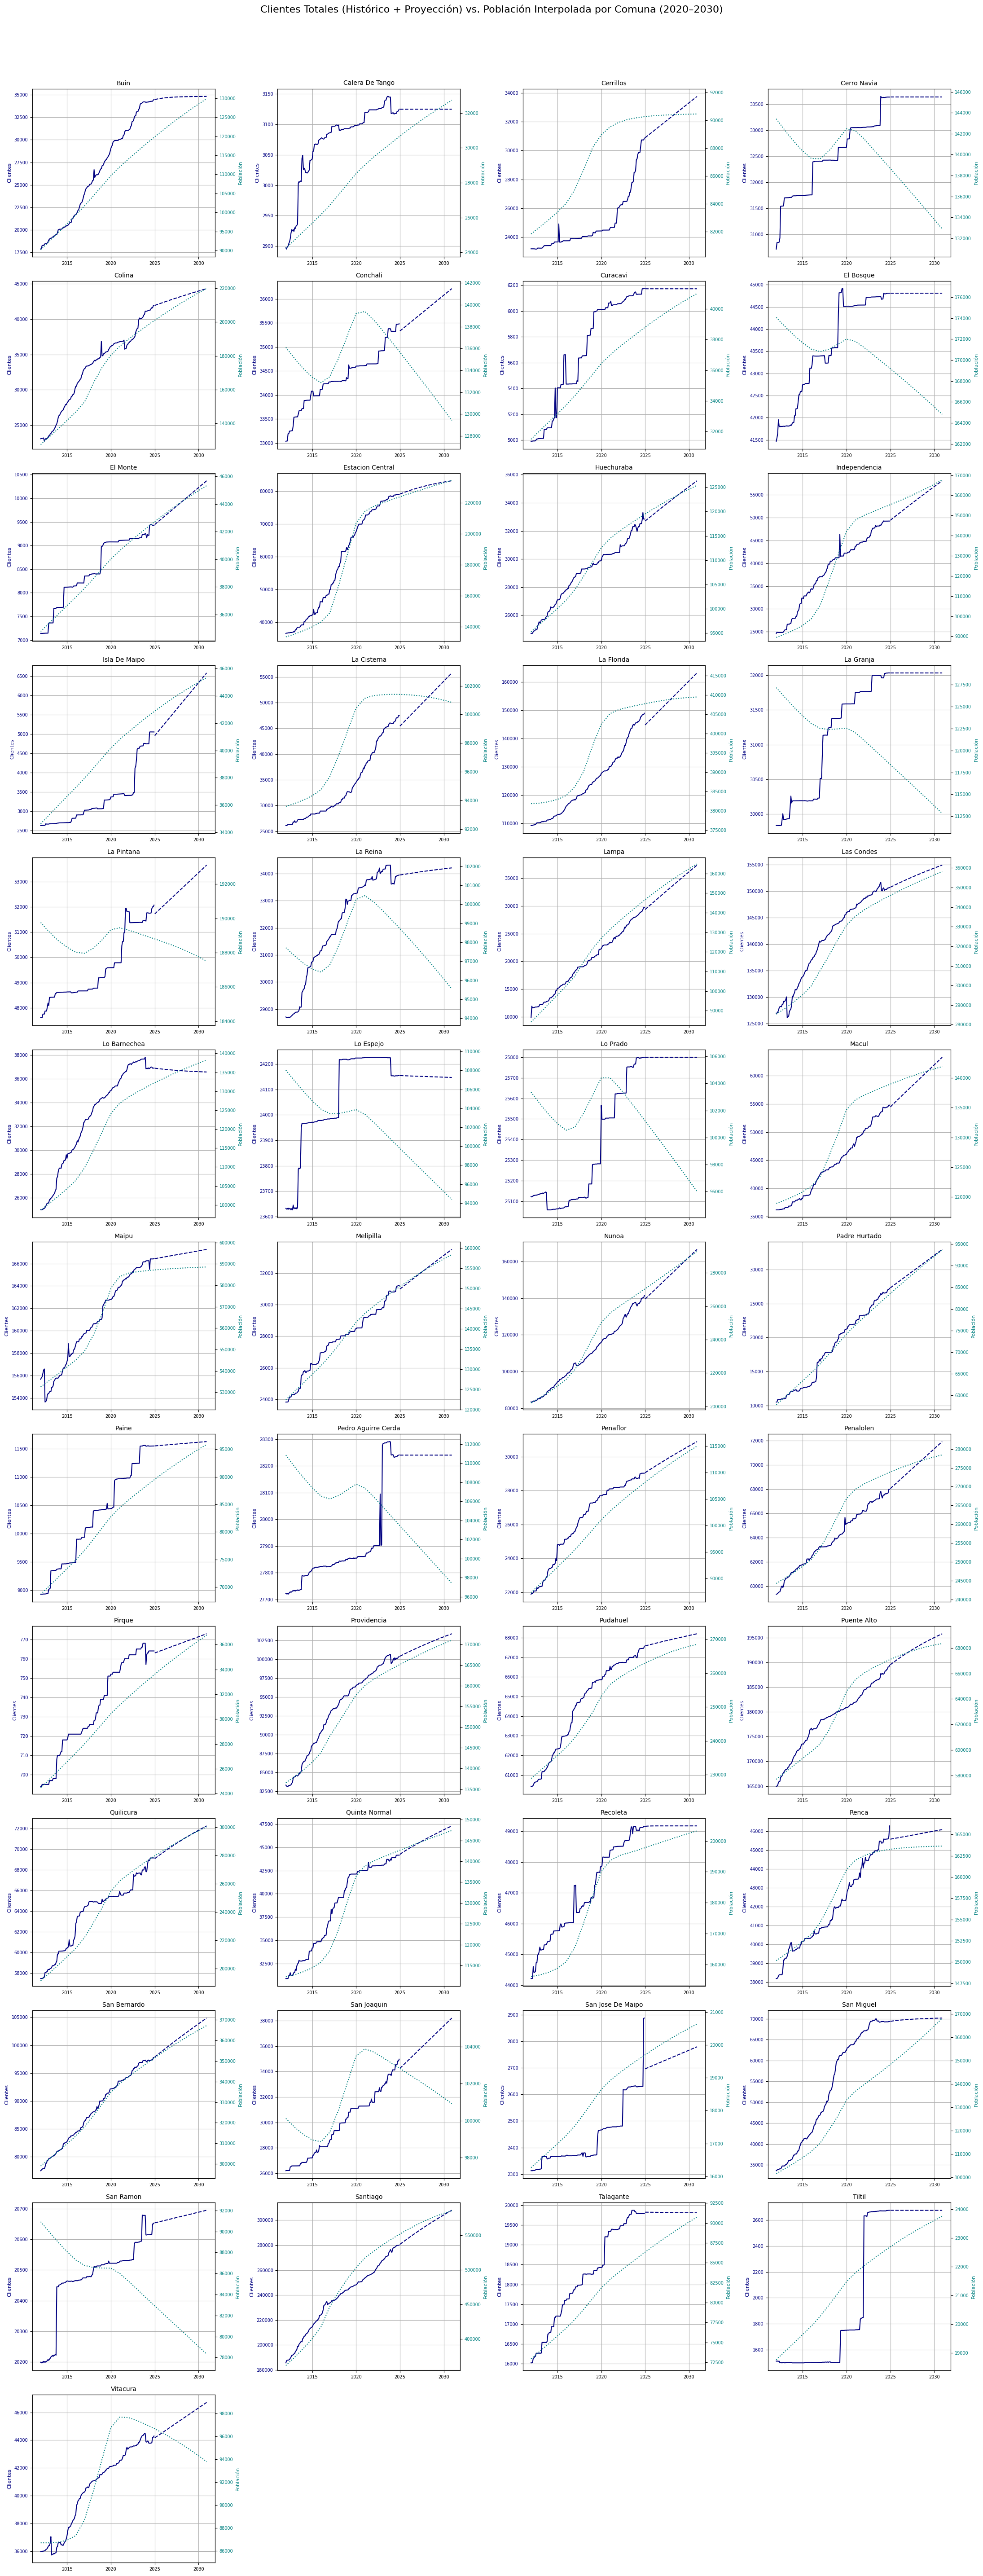

In [30]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import unicodedata

# Asegurar fechas en datetime
df_completo['Fecha'] = pd.to_datetime(df_completo['Fecha'])
df_mensual_interp['Fecha'] = pd.to_datetime(df_mensual_interp['Fecha'])

# Normalizar nombres de comuna
def normalizar_comuna(nombre):
    return unicodedata.normalize('NFKD', nombre).encode('ASCII', 'ignore').decode('utf-8').upper()

df_completo['Comuna'] = df_completo['Comuna'].apply(normalizar_comuna)
df_mensual_interp['Nombre Comuna'] = df_mensual_interp['Nombre Comuna'].apply(normalizar_comuna)

# Agrupar clientes por Fecha, Comuna y Origen (sumando todos los tipos de cliente)
df_clientes_total = (
    df_completo
    .groupby(['Fecha', 'Comuna', 'Origen'], as_index=False)['Clientes']
    .sum()
)

# Comunas en común
comunas = sorted(set(df_clientes_total['Comuna']).intersection(df_mensual_interp['Nombre Comuna']))

# Configurar cuadrícula
n = len(comunas)
cols = 4
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5.5, rows * 4.5), sharex=False)
axes = axes.flatten()

for i, comuna in enumerate(comunas):
    ax1 = axes[i]

    # Filtrar clientes y población
    df_cli = df_clientes_total[df_clientes_total['Comuna'] == comuna]
    df_pob = df_mensual_interp[
        (df_mensual_interp['Nombre Comuna'] == comuna) &
        (df_mensual_interp['Fecha'] >= '2012-01-01') &
        (df_mensual_interp['Fecha'] <= '2030-12-31')
    ]

    if df_cli.empty or df_pob.empty:
        ax1.set_visible(False)
        continue

    # Separar histórico y proyección
    df_hist = df_cli[(df_cli['Origen'] == 'Histórico') & (df_cli['Fecha'] >= '2012-01-01')]
    df_proj = df_cli[(df_cli['Origen'] == 'Proyección') & (df_cli['Fecha'] <= '2030-12-31')]

    # Clientes (eje izquierdo)
    ax1.plot(df_hist['Fecha'], df_hist['Clientes'], label='Histórico', linestyle='-', color='navy', linewidth=1.5)
    ax1.plot(df_proj['Fecha'], df_proj['Clientes'], label='Proyección', linestyle='--', color='navy', linewidth=1.5)
    ax1.set_ylabel('Clientes', color='navy', fontsize=8)
    ax1.tick_params(axis='y', labelcolor='navy', labelsize=7)
    ax1.tick_params(axis='x', labelsize=7)
    ax1.xaxis.set_major_locator(mdates.YearLocator(5))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Población (eje derecho)
    ax2 = ax1.twinx()
    ax2.plot(df_pob['Fecha'], df_pob['Poblacion'], color='teal', linewidth=1.5, linestyle=':', label='Población')
    ax2.set_ylabel('Población', color='teal', fontsize=8)
    ax2.tick_params(axis='y', labelcolor='teal', labelsize=7)

    pob_min = df_pob['Poblacion'].min()
    pob_max = df_pob['Poblacion'].max()
    if np.isfinite(pob_min) and np.isfinite(pob_max):
        ax2.set_ylim(pob_min * 0.98, pob_max * 1.02)

    ax1.set_title(comuna.title(), fontsize=10)
    ax1.grid(True)

# Ocultar ejes vacíos
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Clientes Totales (Histórico + Proyección) vs. Población Interpolada por Comuna (2020–2030)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


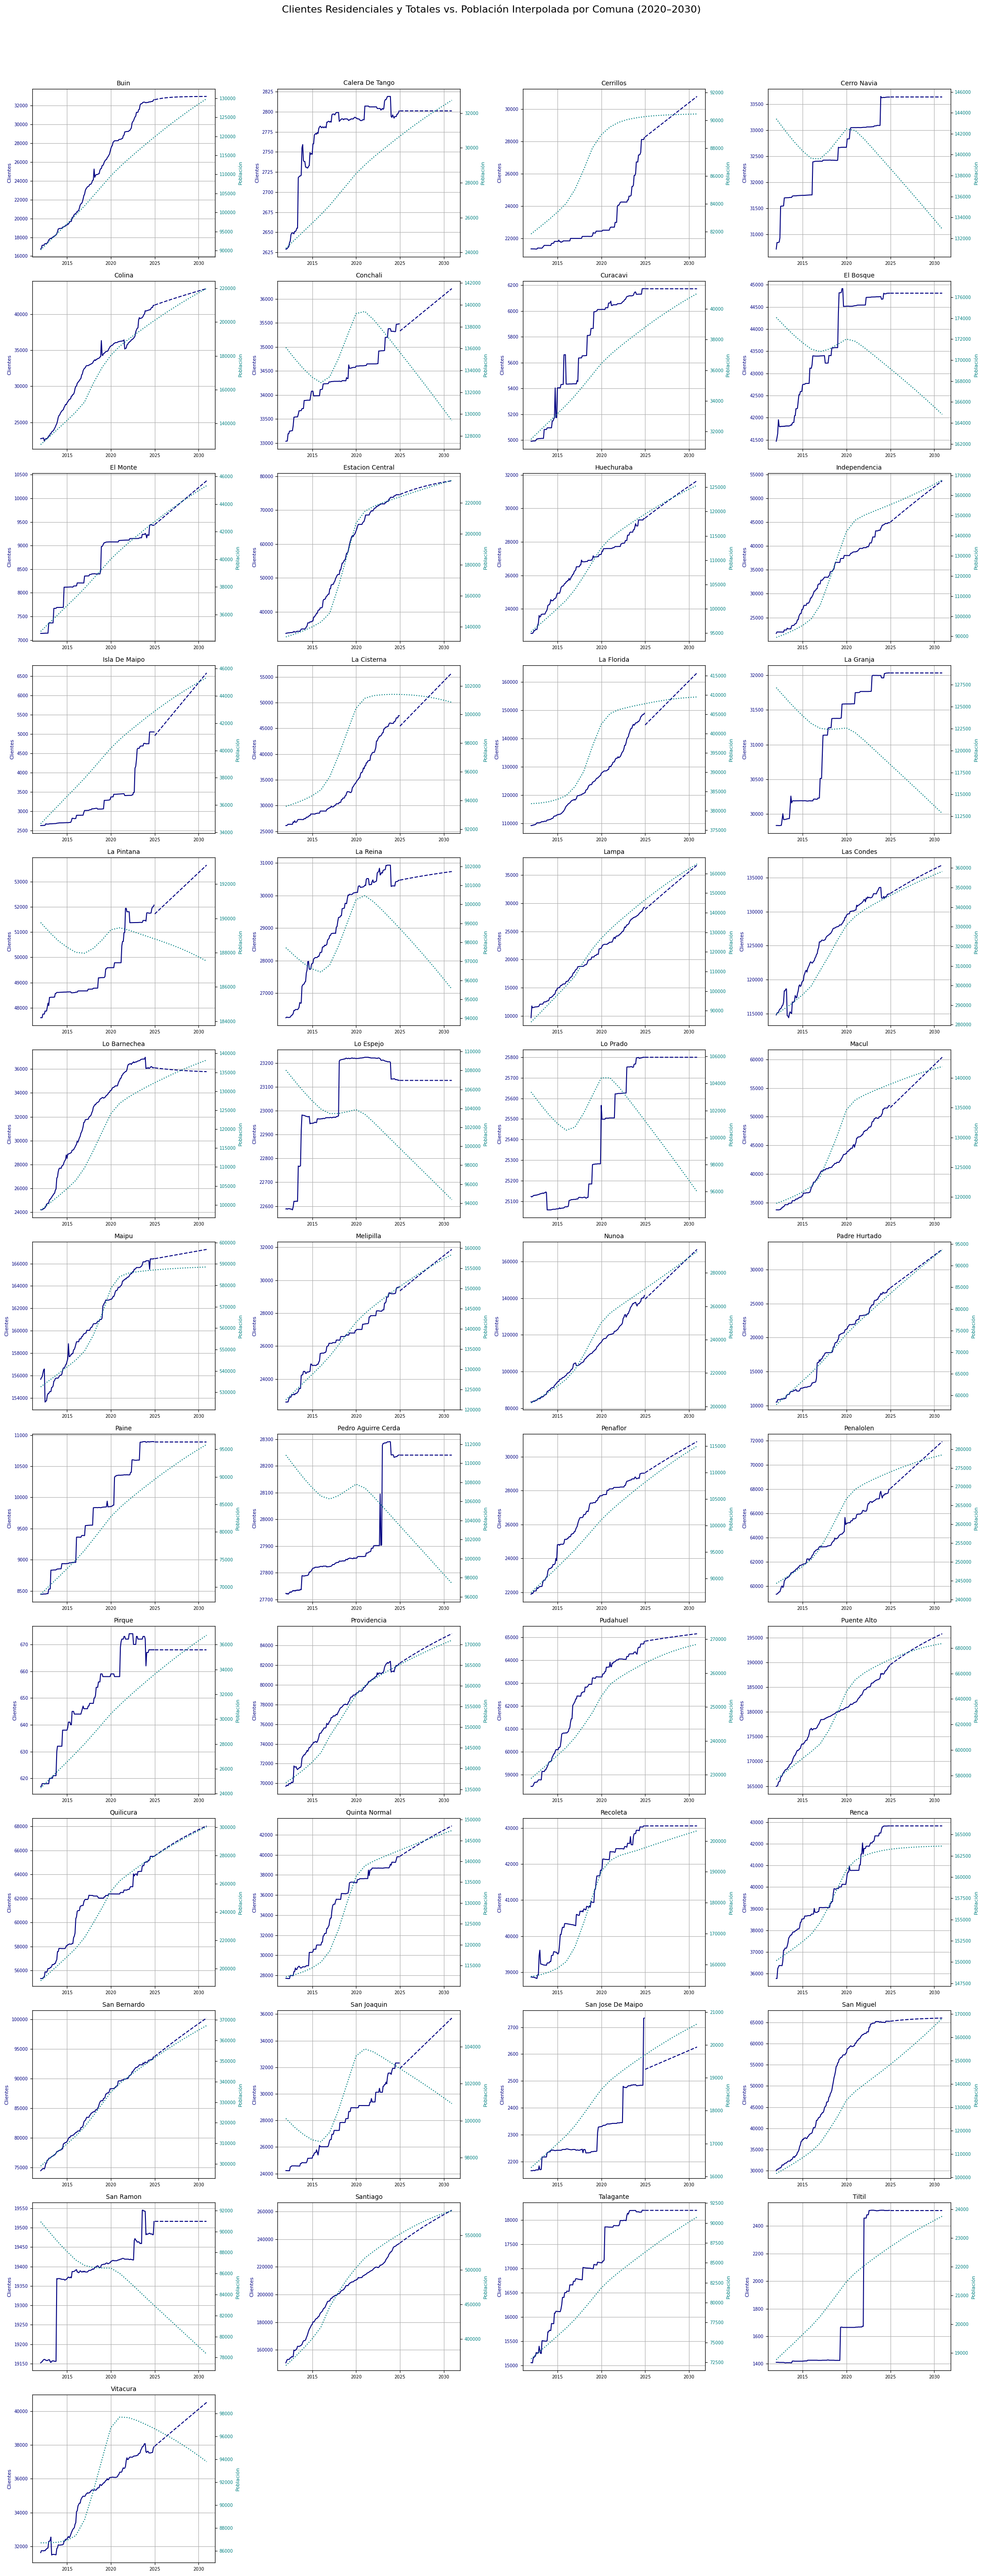

In [31]:
# Asegurar fechas en datetime
df_completo['Fecha'] = pd.to_datetime(df_completo['Fecha'])
df_mensual_interp['Fecha'] = pd.to_datetime(df_mensual_interp['Fecha'])

# Normalizar nombres de comuna
def normalizar_comuna(nombre):
    return unicodedata.normalize('NFKD', nombre).encode('ASCII', 'ignore').decode('utf-8').upper()

df_completo['Comuna'] = df_completo['Comuna'].apply(normalizar_comuna)
df_mensual_interp['Nombre Comuna'] = df_mensual_interp['Nombre Comuna'].apply(normalizar_comuna)

# 🔍 Filtrar solo residenciales y totales
df_filtrado = df_completo[df_completo['Grupo Cliente'].isin(['Residencial', 'Total'])]

# Agrupar por Fecha, Comuna, Origen (sumando clientes)
df_clientes_total = (
    df_filtrado
    .groupby(['Fecha', 'Comuna', 'Origen'], as_index=False)['Clientes']
    .sum()
)

# Comunas en común
comunas = sorted(set(df_clientes_total['Comuna']).intersection(df_mensual_interp['Nombre Comuna']))

# Configurar cuadrícula
n = len(comunas)
cols = 4
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5.5, rows * 4.5), sharex=False)
axes = axes.flatten()

for i, comuna in enumerate(comunas):
    ax1 = axes[i]

    # Filtrar clientes y población
    df_cli = df_clientes_total[df_clientes_total['Comuna'] == comuna]
    df_pob = df_mensual_interp[
        (df_mensual_interp['Nombre Comuna'] == comuna) &
        (df_mensual_interp['Fecha'] >= '2012-01-01') &
        (df_mensual_interp['Fecha'] <= '2030-12-31')
    ]

    if df_cli.empty or df_pob.empty:
        ax1.set_visible(False)
        continue

    # Separar histórico y proyección
    df_hist = df_cli[(df_cli['Origen'] == 'Histórico') & (df_cli['Fecha'] >= '2012-01-01')]
    df_proj = df_cli[(df_cli['Origen'] == 'Proyección') & (df_cli['Fecha'] <= '2030-12-31')]

    # Clientes (eje izquierdo)
    ax1.plot(df_hist['Fecha'], df_hist['Clientes'], label='Histórico', linestyle='-', color='navy', linewidth=1.5)
    ax1.plot(df_proj['Fecha'], df_proj['Clientes'], label='Proyección', linestyle='--', color='navy', linewidth=1.5)
    ax1.set_ylabel('Clientes', color='navy', fontsize=8)
    ax1.tick_params(axis='y', labelcolor='navy', labelsize=7)
    ax1.tick_params(axis='x', labelsize=7)
    ax1.xaxis.set_major_locator(mdates.YearLocator(5))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Población (eje derecho)
    ax2 = ax1.twinx()
    ax2.plot(df_pob['Fecha'], df_pob['Poblacion'], color='teal', linewidth=1.5, linestyle=':', label='Población')
    ax2.set_ylabel('Población', color='teal', fontsize=8)
    ax2.tick_params(axis='y', labelcolor='teal', labelsize=7)

    pob_min = df_pob['Poblacion'].min()
    pob_max = df_pob['Poblacion'].max()
    if np.isfinite(pob_min) and np.isfinite(pob_max):
        ax2.set_ylim(pob_min * 0.98, pob_max * 1.02)

    ax1.set_title(comuna.title(), fontsize=10)
    ax1.grid(True)

# Ocultar ejes vacíos
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Clientes Residenciales y Totales vs. Población Interpolada por Comuna (2020–2030)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Rescatar resultados

In [32]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [81]:
# Agrupar por las columnas deseadas y sumar las métricas numéricas
df_historico = (
    df_agua_final
    .drop(columns=["Comuna"])  # Eliminar columna Comuna
    .groupby(["Fecha", "Nombre Corto", "Localidad", "Grupo Cliente"], as_index=False)
    .agg({"M3 Ap": "sum", "Clientes": "sum"})
)

In [87]:
df_historico.head()

Fecha   Nombre Corto                                      Localidad  \
0 2012-01-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
1 2012-01-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
2 2012-01-01  AGUAS ANDINAS                                CALERA DE TANGO   
3 2012-01-01  AGUAS ANDINAS                                CALERA DE TANGO   
4 2012-01-01  AGUAS ANDINAS                                       CURACAVI   

    Grupo Cliente      M3 Ap  Clientes  
0  No Residencial  207283.90    1594.0  
1     Residencial  575856.50   24783.0  
2  No Residencial   51454.45     268.0  
3     Residencial  134067.79    2629.0  
4     Residencial  125545.88    4991.0

In [90]:
# Filtrar datos relevantes
df_filtrado = df_historico[
    (df_historico["Nombre Corto"] == "AGUAS ANDINAS") &
    (df_historico["Grupo Cliente"].isin(["Residencial", "No Residencial"])) &
    (df_historico["Localidad"].str.contains("BUIN|PAINE|LINDEROS|MAIPO|ALTO JAHUEL", case=False))
]

# Pivotear para tener una columna por grupo cliente
df_hist_AA = df_filtrado.pivot_table(
    index="Fecha",
    columns="Grupo Cliente",
    values="Clientes",
    aggfunc="sum"
).reset_index()

# Renombrar columnas para claridad
df_hist_AA.columns.name = None
df_hist_AA = df_hist_AA.rename(columns={
    "Residencial": "Residencial",
    "No Residencial": "No Residencial"
})


In [91]:
df_hist_AA

Fecha  No Residencial  Residencial
0   2012-01-01          1741.0      29137.0
1   2012-02-01          1738.0      29235.0
2   2012-03-01          1744.0      29245.0
3   2012-04-01          1744.0      29245.0
4   2012-05-01          1749.0      29248.0
..         ...             ...          ...
151 2024-08-01          2642.0      44628.0
152 2024-09-01          2642.0      44640.0
153 2024-10-01          2641.0      44644.0
154 2024-11-01          2650.0      44993.0
155 2024-12-01          2652.0      45004.0

[156 rows x 3 columns]

In [93]:
# 3. Filtrar proyecciones desde 2025 en adelante
df_proj = df_proyecciones[
    (df_proyecciones["Nombre Corto"] == "AGUAS ANDINAS") &
    (df_proyecciones["Grupo Cliente"].isin(["Residencial", "No Residencial"])) &
    (df_proyecciones["Localidad"].str.contains("BUIN|PAINE|LINDEROS|MAIPO|ALTO JAHUEL", case=False)) &
    (df_proyecciones["Fecha"] >= "2025-01-01")
]

# 4. Pivotear proyecciones
df_proj_pivot = df_proj.pivot_table(
    index="Fecha",
    columns="Grupo Cliente",
    values="Clientes",
    aggfunc="sum"
).reset_index()

df_proj_pivot.columns.name = None  # Limpiar nombre de columnas

# 5. Unir histórico + proyecciones
df_AA_BPLMA_total = pd.concat([df_hist_AA, df_proj_pivot], ignore_index=True)
df_AA_BPLMA_total = df_AA_BPLMA_total.sort_values("Fecha").reset_index(drop=True)

In [95]:
df_AA_BPLMA_total.tail()

Fecha  No Residencial   Residencial
223 2030-08-01     2744.395629  45257.426064
224 2030-09-01     2745.254138  45259.047128
225 2030-10-01     2746.112642  45260.643609
226 2030-11-01     2746.971140  45262.216846
227 2030-12-01     2747.829632  45263.768105

# Proyección dotación de consumo

## Preprocesamiento

#### Librerías

In [37]:
#!pip install feature_engine

In [38]:
from feature_engine.creation import CyclicalFeatures
from tqdm.auto import tqdm
# ==============================================================================
# Librerías estándar
# ==============================================================================
import json
import random
import time
import unicodedata
from itertools import product
from urllib.request import urlopen
from datetime import datetime
import ast

# ==============================================================================
# IPython
# ==============================================================================
import IPython
import IPython.display

# ==============================================================================
# Manejo y procesamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from dateutil.parser import parse


from feature_engine.creation import CyclicalFeatures
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
# ==============================================================================
# Visualización
# ==============================================================================
import altair as alt
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from pandas.plotting import autocorrelation_plot, lag_plot
from tqdm.auto import tqdm

# ==============================================================================
# Estadística y análisis de series de tiempo
# ==============================================================================
import phik
from phik import report
from phik.report import plot_correlation_matrix
from scipy import signal, stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.tsa as tsm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse, rmspe
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller, grangercausalitytests, kpss, pacf
from arch.unitroot import PhillipsPerron

# ==============================================================================
# Forecasting y modelos estadísticos avanzados
# ==============================================================================
from prophet import Prophet
import pmdarima as pm
from sktime import forecasting
from sktime.forecasting.all import (
    Deseasonalizer, Detrender,
    ForecastingHorizon,
    mean_absolute_percentage_error as mape_sktime,
    mean_squared_error as mse,
    mean_squared_percentage_error as mspe,
    NaiveForecaster,
    PolynomialTrendForecaster,
    temporal_train_test_split,
    TransformedTargetForecaster
)
from sktime.forecasting.compose import make_reduction
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

#### Funciones

In [39]:
# La función split_data(data, test_split) divide un conjunto de datos en dos partes: un conjunto de entrenamiento y uno de prueba.
# El parámetro test_split define la proporción de los datos que se destinarán al conjunto de prueba. La función imprime las longitudes de ambos conjuntos y los retorna.
def split_data(data, test_split, print_len = True):
    l = len(data)
    t_idx = round(l*(1-test_split))
    train, test = data[ :t_idx], data[t_idx: ]
    if print_len:
        print(f'train: {len(train)} , test: {len(test)}')
    return train, test

In [40]:
# Esta función genera combinaciones de elementos a partir de una lista de elementos dada. 
# Utiliza el producto cartesiano para combinar los elementos en tuplas, repitiendo los elementos según lo especificado en el parámetro r.
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]
    return combo

In [41]:
def get_best_row(df, metric):
    return df.loc[df[metric].idxmin()]

In [42]:
# La función get_error_metrics(...) calcula métricas de error (RMSE, MAPE y RMSPE) entre predicciones y valores reales,
#  y retorna un DataFrame con los resultados etiquetados según el modelo y la técnica utilizados.
def get_error_metrics(y_pred, y_test, model, technique):

    # Calcular métricas de error
    residuals = y_test.values - y_pred.values
    rmse = np.sqrt(np.mean(residuals**2))
    mape = np.mean(np.abs(residuals / y_test.values)) 
    rmspe = np.sqrt(np.mean((residuals / y_test.values) ** 2))

    # Crear un registro con los resultados del modelo
    nuevo_resultado = {
        "Model" : [f"{model}-{technique}"],
        "RMSPE": rmspe,
        "RMSE": rmse,
        "MAPE": mape
    }

    return pd.DataFrame(nuevo_resultado)

#### Preprocesamiento

In [43]:
df_agua_final.head()

Fecha   Nombre Corto                                      Localidad  \
0 2012-01-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
1 2012-01-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
2 2012-01-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
3 2012-01-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
4 2012-01-01  AGUAS ANDINAS                                CALERA DE TANGO   

            Comuna   Grupo Cliente      M3 Ap  Clientes  
0             BUIN  No Residencial  149980.55    1110.0  
1             BUIN     Residencial  406371.24   16337.0  
2            PAINE  No Residencial   57303.35     484.0  
3            PAINE     Residencial  169485.26    8446.0  
4  CALERA DE TANGO  No Residencial   51454.45     268.0

In [44]:
df_dotacion_consumo_localidades = (
    df_agua_final
    .drop(columns=['Comuna', 'Grupo Cliente'])
    .groupby(['Fecha', 'Nombre Corto', 'Localidad'], as_index=False)['M3 Ap', 'Clientes']
    .mean()
)

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


In [45]:
df_dotacion_consumo = (
    df_agua_final
    .drop(columns='Comuna')
    .groupby(['Fecha', 'Nombre Corto', 'Localidad', 'Grupo Cliente'], as_index=False)['M3 Ap', 'Clientes']
    .sum()
)

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


In [46]:
df_dotacion_consumo_localidades['dotacion_consumo'] = df_dotacion_consumo_localidades['M3 Ap'] / df_dotacion_consumo_localidades['Clientes']
df_dotacion_consumo['dotacion_consumo'] = df_dotacion_consumo['M3 Ap'] / df_dotacion_consumo['Clientes']


In [47]:
df_dotacion_consumo_localidades = df_dotacion_consumo_localidades.drop(columns=["Clientes", "M3 Ap"])
df_dotacion_consumo = df_dotacion_consumo.drop(columns=["Clientes", "M3 Ap"])

In [48]:
df_dotacion_consumo_localidades['Año'] = df_dotacion_consumo_localidades['Fecha'].dt.year
df_dotacion_consumo_localidades['Mes'] = df_dotacion_consumo_localidades['Fecha'].dt.month
df_dotacion_consumo['Año'] = df_dotacion_consumo['Fecha'].dt.year
df_dotacion_consumo['Mes'] = df_dotacion_consumo['Fecha'].dt.month

In [49]:
df_dotacion_consumo_localidades.head()

Fecha   Nombre Corto                                      Localidad  \
0 2012-01-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
1 2012-01-01  AGUAS ANDINAS                                CALERA DE TANGO   
2 2012-01-01  AGUAS ANDINAS                                       CURACAVI   
3 2012-01-01  AGUAS ANDINAS                            EL MONTE - EL PAICO   
4 2012-01-01  AGUAS ANDINAS                                  GRAN SANTIAGO   

   dotacion_consumo   Año  Mes  
0         29.690276  2012    1  
1         64.039434  2012    1  
2         25.154454  2012    1  
3         20.841526  2012    1  
4         26.242636  2012    1

In [50]:
df_dotacion_consumo.head()

Fecha   Nombre Corto                                      Localidad  \
0 2012-01-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
1 2012-01-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
2 2012-01-01  AGUAS ANDINAS                                CALERA DE TANGO   
3 2012-01-01  AGUAS ANDINAS                                CALERA DE TANGO   
4 2012-01-01  AGUAS ANDINAS                                       CURACAVI   

    Grupo Cliente  dotacion_consumo   Año  Mes  
0  No Residencial        130.040088  2012    1  
1     Residencial         23.235948  2012    1  
2  No Residencial        191.994216  2012    1  
3     Residencial         50.995736  2012    1  
4     Residencial         25.154454  2012    1

In [51]:
df_dotacion_consumo_localidades[(df_dotacion_consumo_localidades["Localidad"]== "BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL") ]

Fecha   Nombre Corto                                      Localidad  \
0    2012-01-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
50   2012-02-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
100  2012-03-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
151  2012-04-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
202  2012-05-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
...         ...            ...                                            ...   
8380 2024-08-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
8438 2024-09-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
8496 2024-10-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
8554 2024-11-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
8612 2024-12-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   

      dotacion_consumo   Año  Mes  
0            29.690276  2012    1  
50           28.043307  2012    2  
100          28.316723  2012    3  
151          24.626753  2012    4  
202          22.514072  2012    5  
...                ...   ...  ...  
8380         19.530984  2024    8  
8438         19.752884  2024    9  
8496         20.184499  2024   10  
8554         22.160827  2024   11  
8612         23.884290  2024   12  

[156 rows x 6 columns]

In [52]:
df_dotacion_consumo[(df_dotacion_consumo["Localidad"]== "BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL") ]

Fecha   Nombre Corto  \
0     2012-01-01  AGUAS ANDINAS   
1     2012-01-01  AGUAS ANDINAS   
70    2012-02-01  AGUAS ANDINAS   
71    2012-02-01  AGUAS ANDINAS   
140   2012-03-01  AGUAS ANDINAS   
...          ...            ...   
12877 2024-10-01  AGUAS ANDINAS   
12969 2024-11-01  AGUAS ANDINAS   
12970 2024-11-01  AGUAS ANDINAS   
13062 2024-12-01  AGUAS ANDINAS   
13063 2024-12-01  AGUAS ANDINAS   

                                           Localidad   Grupo Cliente  \
0      BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL  No Residencial   
1      BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL     Residencial   
70     BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL  No Residencial   
71     BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL     Residencial   
140    BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL  No Residencial   
...                                              ...             ...   
12877  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL     Residencial   
12969  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL  No Residencial   
12970  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL     Residencial   
13062  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL  No Residencial   
13063  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL     Residencial   

       dotacion_consumo   Año  Mes  
0            130.040088  2012    1  
1             23.235948  2012    1  
70           120.436631  2012    2  
71            22.135273  2012    2  
140          130.777207  2012    3  
...                 ...   ...  ...  
12877         16.237439  2024   10  
12969         88.559219  2024   11  
12970         17.946262  2024   11  
13062         96.750724  2024   12  
13063         19.256644  2024   12  

[312 rows x 7 columns]

In [53]:
df_dotacion_consumo[(df_dotacion_consumo["Localidad"]== "BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL") & (df_dotacion_consumo["Grupo Cliente"]=="Residencial")]

Fecha   Nombre Corto  \
1     2012-01-01  AGUAS ANDINAS   
71    2012-02-01  AGUAS ANDINAS   
141   2012-03-01  AGUAS ANDINAS   
212   2012-04-01  AGUAS ANDINAS   
283   2012-05-01  AGUAS ANDINAS   
...          ...            ...   
12691 2024-08-01  AGUAS ANDINAS   
12784 2024-09-01  AGUAS ANDINAS   
12877 2024-10-01  AGUAS ANDINAS   
12970 2024-11-01  AGUAS ANDINAS   
13063 2024-12-01  AGUAS ANDINAS   

                                           Localidad Grupo Cliente  \
1      BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   Residencial   
71     BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   Residencial   
141    BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   Residencial   
212    BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   Residencial   
283    BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   Residencial   
...                                              ...           ...   
12691  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   Residencial   
12784  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   Residencial   
12877  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   Residencial   
12970  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   Residencial   
13063  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   Residencial   

       dotacion_consumo   Año  Mes  
1             23.235948  2012    1  
71            22.135273  2012    2  
141           21.742357  2012    3  
212           19.213446  2012    4  
283           17.627625  2012    5  
...                 ...   ...  ...  
12691         15.895272  2024    8  
12784         15.943958  2024    9  
12877         16.237439  2024   10  
12970         17.946262  2024   11  
13063         19.256644  2024   12  

[156 rows x 7 columns]

In [54]:
(
    df_dotacion_consumo_localidades[
        (df_dotacion_consumo_localidades["Localidad"] == "BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL") 
    ]
    .groupby("Año", as_index=False)["dotacion_consumo"]
    .agg(["mean", "max"])
    .rename(columns={"mean": "media", "max": "maximo"})
    .reset_index()
)

Año      media     maximo
0   2012  23.937517  29.690276
1   2013  24.316466  28.383073
2   2014  24.355366  30.191485
3   2015  23.831431  28.345601
4   2016  23.974017  27.718670
5   2017  23.870575  28.343417
6   2018  24.079400  28.039362
7   2019  23.631430  27.508635
8   2020  22.739175  26.540432
9   2021  23.348921  26.146455
10  2022  22.577982  25.447366
11  2023  21.755606  24.944666
12  2024  21.927050  24.342045

In [55]:
(
    df_dotacion_consumo[
        (df_dotacion_consumo["Localidad"] == "BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL") &
        (df_dotacion_consumo["Grupo Cliente"] == "Residencial")
    ]
    .groupby("Año", as_index=False)["dotacion_consumo"]
    .agg(["mean", "max"])
    .rename(columns={"mean": "media", "max": "maximo"})
    .reset_index()
)

Año      media     maximo
0   2012  18.957695  23.235948
1   2013  19.161252  22.488813
2   2014  19.098349  23.633650
3   2015  18.698829  22.430717
4   2016  18.864947  21.113475
5   2017  18.888871  22.274102
6   2018  19.175963  22.239645
7   2019  18.757906  21.699139
8   2020  18.562441  21.081632
9   2021  19.156451  21.358815
10  2022  18.307920  20.579802
11  2023  17.687289  19.819314
12  2024  17.854124  20.234716

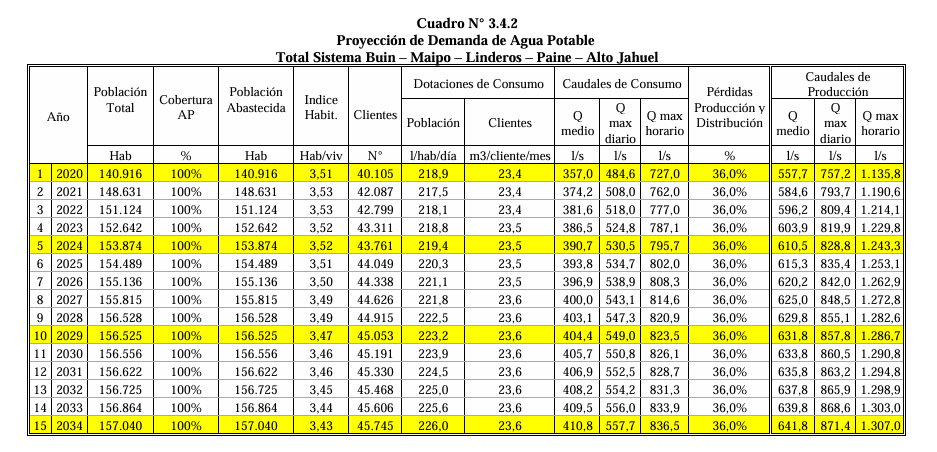

In [56]:
df_dotacion_consumo.to_csv('df_dotacion_consumo.csv', index=False)

In [57]:
df_dotacion_consumo_localidades.to_csv('df_dotacion_consumo_localidades.csv', index=False)

## Proyección

### Preprocesamiento

In [58]:
df_dotacion_consumo.info()

In [59]:
df_dotacion_consumo_localidades.head()

Fecha   Nombre Corto                                      Localidad  \
0 2012-01-01  AGUAS ANDINAS  BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL   
1 2012-01-01  AGUAS ANDINAS                                CALERA DE TANGO   
2 2012-01-01  AGUAS ANDINAS                                       CURACAVI   
3 2012-01-01  AGUAS ANDINAS                            EL MONTE - EL PAICO   
4 2012-01-01  AGUAS ANDINAS                                  GRAN SANTIAGO   

   dotacion_consumo   Año  Mes  
0         29.690276  2012    1  
1         64.039434  2012    1  
2         25.154454  2012    1  
3         20.841526  2012    1  
4         26.242636  2012    1

In [60]:
def preprocesamiento_dotacion(df, localidad=None, empresa=None):
    # Agrupación por claves relevantes
    df = df.groupby(by=['Fecha', 'Año', 'Mes', 'Nombre Corto', 'Localidad', 'Grupo Cliente'], as_index=False).agg({
        'dotacion_consumo': 'sum'  # o 'mean', según lo que tenga más sentido
    })

    # Orden y formato de fecha
    df = df.sort_values(by="Fecha", ascending=True)
    df = df.set_index("Fecha", drop=False).rename_axis('idx_fecha')

    # Filtro por localidad y empresa si se especifica
    if (localidad is not None) and (empresa is not None):
        df = df[(df["Localidad"].isin(localidad)) & (df["Nombre Corto"].isin(empresa))]

    # Crear ID de combinación
    df["id_combinacion"] = df["Localidad"] + ";" + df["Nombre Corto"] + ";" + df["Grupo Cliente"]

    # Transformación cíclica del mes
    cyclical_encoder = CyclicalFeatures(
        variables=["Mes"],
        max_values={"Mes": 12},
        drop_original=True
    )
    df = cyclical_encoder.fit_transform(df)

    # Variables exógenas
    exog_features = [col for col in df.columns if col not in ["Nombre Corto", "Localidad", "Grupo Cliente", "dotacion_consumo", "id_combinacion", "Fecha"]]

    # Filtrar combinaciones incompletas, inválidas o con valores infinitos
    combinaciones = df["id_combinacion"].drop_duplicates()
    for id in combinaciones:
        mask = df["id_combinacion"] == id
        subset = df.loc[mask]

        # Reemplazar infinitos por NaN para detección unificada
        subset = subset.replace([np.inf, -np.inf], np.nan)

        if (
            subset.isnull().any(axis=None)
            or subset.shape[0] < 156
            or (subset["dotacion_consumo"] == 0).any()
        ):
            df = df[~mask]
            print(f"Se eliminó la combinación: {id}")

    combinaciones = df["id_combinacion"].drop_duplicates()

    return df, exog_features, combinaciones


In [61]:
df, exog_features, combinations = preprocesamiento_dotacion(df_dotacion_consumo)

In [62]:
df.describe()

Año  dotacion_consumo       Mes_sin       Mes_cos
count  10296.000000      10296.000000  1.029600e+04  1.029600e+04
mean    2018.000000         88.795409 -1.104185e-17 -1.104185e-16
std        3.741839        198.622375  7.071411e-01  7.071411e-01
min     2012.000000          0.455446 -1.000000e+00 -1.000000e+00
25%     2015.000000         19.607927 -5.915064e-01 -5.915064e-01
50%     2018.000000         38.791744 -6.123234e-17 -6.123234e-17
75%     2021.000000         98.829376  5.915064e-01  5.915064e-01
max     2024.000000       6923.500000  1.000000e+00  1.000000e+00

In [63]:
from statsmodels.tsa.stattools import adfuller, kpss

estacionariedad_id = pd.DataFrame(columns=["id_combinacion", "p-valor", "Estacionaria"])

for id in tqdm(combinations, desc="Estacionariedad",disable=True):
    # Get df_comuna for the id
    data_1 = df[df['id_combinacion'] == id]
    data_1 = data_1.reset_index(drop=True)

    adf_test = adfuller(data_1["dotacion_consumo"])
    p_value = adf_test[1]
    estacionaria = 1 if p_value < 0.05 else 0

    estacionariedad_id.loc[len(estacionariedad_id)] = [data_1["id_combinacion"].values[0], p_value, estacionaria]

In [64]:
metrics_per_comuna = pd.DataFrame(columns=["id_combinacion","Model", "MAPE","RMSE", "RMSPE","Time"])

#Aqui se guardará, por cada id_combinacion, el modelo usado, los datos de testeo, predicciones y erorres
forecast_results = pd.DataFrame()

# Table of results for all Models
# ==============================================================================
table_results = pd.DataFrame(columns=['Model','MAPE', 'RMSE', 'RMSPE', 'Time'])
table_results = table_results.set_index('Model')
table_results = table_results.astype({'MAPE':float, 'RMSE':float, 'RMSPE':float, 'Time': object})

### Entrenamiento

In [65]:
score = {}
start_time = datetime.now()
for id in tqdm(estacionariedad_id["id_combinacion"], desc="ARIMA training"):
    df_forecast = df[(df["id_combinacion"] == id)]
    df_forecast = df_forecast.set_index("Fecha").sort_index()

    # Split train/test
    water_train, water_test = split_data(df_forecast["dotacion_consumo"].reset_index(drop=True), 60/156, False)

    if len(water_test) != 60 or len(water_train) !=96:
        print(f"Error de tamaño de splits en {id}, con train: {len(water_train)} y test {len(water_test)}")
        break

    # Verificar estacionariedad y ajustar valores de d
    estacionaria = estacionariedad_id.loc[estacionariedad_id['id_combinacion'] == id, 'Estacionaria'].values[0]
    if estacionaria == 0:
        pv, qv = [list(range(5))] * 2  # p y q valores de 0 a 5
        dv = list(range(3))  # si no es estacionaria, probar d de 0 a 1
    else:
        pv, qv = [list(range(5))] * 2  # p y q valores de 0 a 5
        dv = list(range(1))            # d inicialmente solo 0
        
    vals = combinator([pv, dv, qv])  # recalcular combinaciones con nuevo dv

    for i, (p, d, q) in enumerate(vals):
        # Definir tendencia según d
        if d >= 1:
            t = "n"
        elif d == 0:
            t = "c"
        else:
            t = "n"

        try:
            m = sm.tsa.arima.ARIMA(water_train, order=(p, d, q), trend=t)
            res = m.fit()

            y = water_test.values.ravel()
            y_hat = res.forecast(steps=len(y))

            score_key = f"{id}_{i}"
            score[score_key] = {
                'order': (p, d, q),
                'ID': id,
                'Technique': "ARIMA",
                'AIC': res.aic,
                'BIC': res.bic,
                'AICc': res.aicc,
                'RMSPE': np.sqrt(np.mean(((y - y_hat) / y) ** 2)) * 100,
                'RMSE': np.sqrt(np.mean((y - y_hat)**2)),
                'MAPE': np.mean(np.abs((y - y_hat) / y)) ,
                'model': res
            }
        except Exception as e:
            print(f"Error en {id} con orden ({p},{d},{q}): {e}")
            continue

model_score = pd.DataFrame.from_dict(score, orient='index')

ARIMA training:   0%|          | 0/66 [00:00<?, ?it/s]

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-package

In [66]:
rng = np.random.default_rng(42)
# IDs que quieres asegurar
ids_fijos = [
    "BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL;AGUAS ANDINAS;Residencial",
    "BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL;AGUAS ANDINAS;No Residencial"
]

# Selección aleatoria (excluyendo los fijos para evitar duplicados)
ids_disponibles = df["id_combinacion"].drop_duplicates()
ids_sin_fijos = ids_disponibles[~ids_disponibles.isin(ids_fijos)]

# Elegir aleatoriamente 4 adicionales (para un total de 6)
selected_random = rng.choice(ids_sin_fijos, size=4, replace=False)

# Combinar con los fijos
selected_local = list(selected_random) + ids_fijos


### Modelo

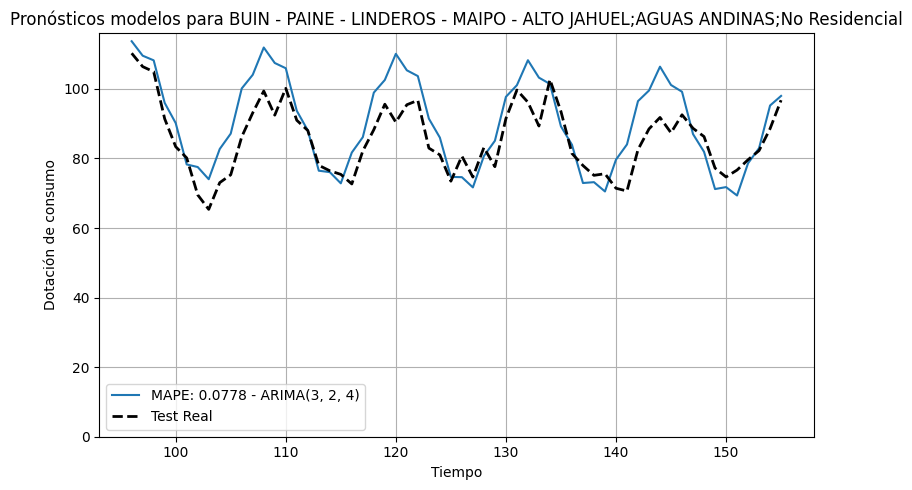

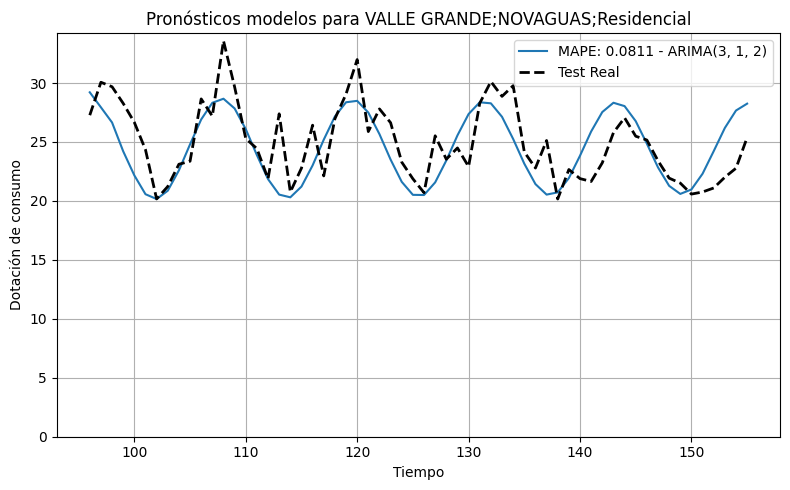

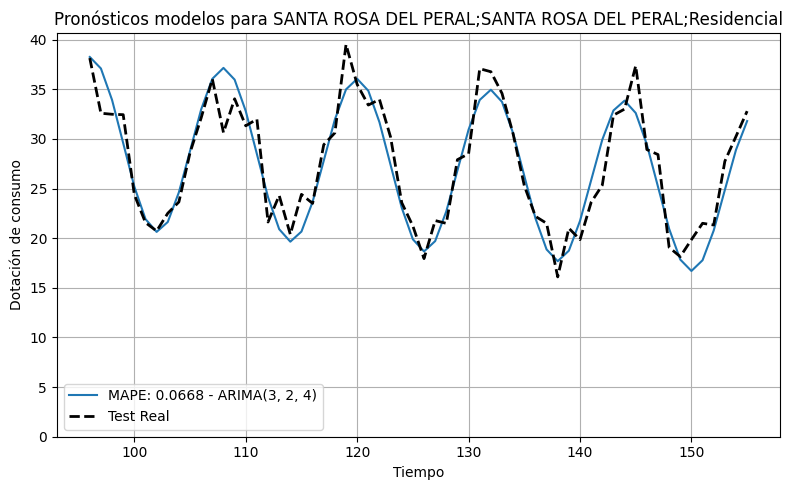

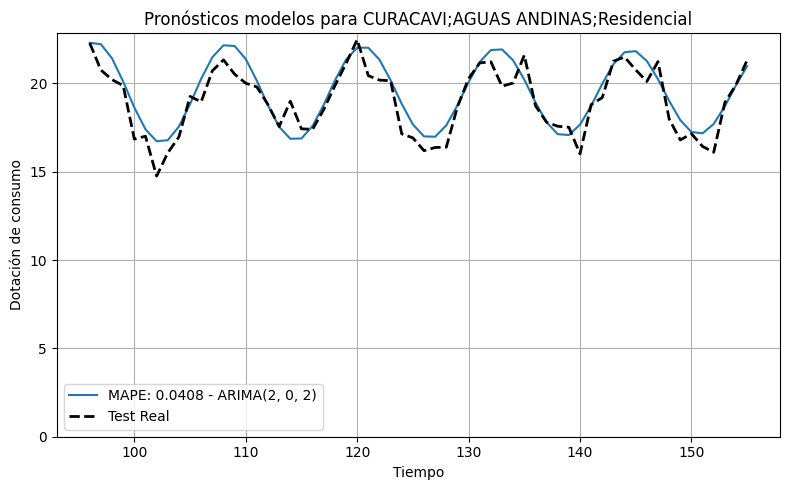

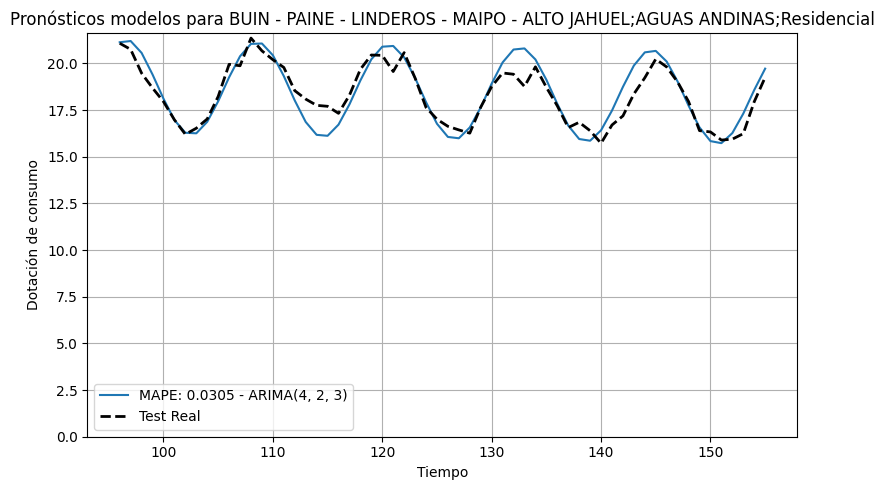

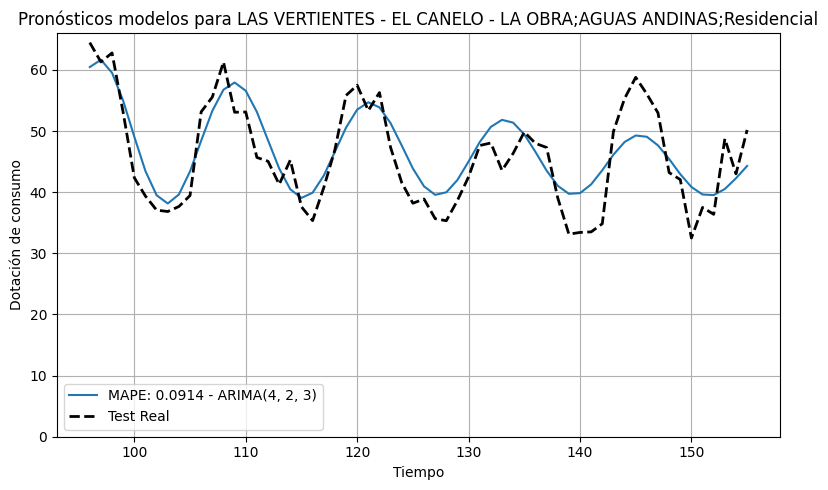

In [67]:
from datetime import datetime
import matplotlib.pyplot as plt

# Métricas a evaluar
metrics = ['RMSPE']
forecast_arima = {}

# IDs que quieres guardar aparte
id_residencial = "BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL;AGUAS ANDINAS;Residencial"
id_no_residencial = "BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL;AGUAS ANDINAS;No Residencial"

# Inicializar variables para guardar los modelos específicos
modelo_residencial = None
orden_residencial = None
modelo_no_residencial = None
orden_no_residencial = None

for i, id in enumerate(df["id_combinacion"].drop_duplicates().to_list()):
    arima_results = []

    for metric in metrics:
        df_ml = model_score[model_score['ID'] == id]
        best_row = get_best_row(df_ml, metric)
        model = best_row['model']
        order = best_row['order']
        error_mape = best_row["MAPE"]
        error_rmse = best_row["RMSE"]
        error_rmspe = best_row["RMSPE"]

        # Guardar el modelo si es uno de los dos que te interesan
        if id == id_residencial:
            modelo_residencial = model
            orden_residencial = order
        elif id == id_no_residencial:
            modelo_no_residencial = model
            orden_no_residencial = order

        df_aux = df[df["id_combinacion"] == id]
        df_forecast = df_aux.set_index("Fecha").sort_index()
        series = df_forecast["dotacion_consumo"].reset_index(drop=True)

        water_train, water_test = split_data(series, 60 / 156, False)
        n_periods = 60
        forecast = model.forecast(steps=n_periods)

        arima_results.append({
            'metric': {"MAPE": error_mape, "RMSE": error_rmse, "RMSPE": error_rmspe},
            'order': order,
            'water_test': water_test,
            'forecast': forecast,
            'fecha': df_aux["Fecha"][-n_periods:]
        })

        forecast_arima[id] = [{
            'metric': {"MAPE": error_mape, "RMSE": error_rmse, "RMSPE": error_rmspe},
            'order': order,
            'water_test': water_test,
            'forecast': forecast,
            'model': model,
            'fecha': df_aux["Fecha"][-n_periods:]
        }]

    if id in selected_local:
        plt.figure(figsize=(8, 5))

        for res in arima_results:
            plt.plot(res['forecast'].index, res['forecast'], label=f"MAPE: {res['metric']['MAPE']:.4f} - ARIMA{res['order']}")

        plt.plot(
            arima_results[0]['water_test'].index,
            arima_results[0]['water_test'],
            label='Test Real',
            color='black', linestyle='--', linewidth=2
        )

        plt.title(f"Pronósticos modelos para {id}")
        plt.xlabel("Tiempo")
        plt.ylabel("Dotación de consumo")
        plt.ylim(bottom=0)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

end_time = datetime.now()


In [68]:
rows = []

for id_val, entries in forecast_arima.items():
    for entry in entries:
        water = entry['water_test']
        forecast = entry['forecast']
        fecha = entry['fecha']
        for i, (wt, fc, fech) in enumerate(zip(water, forecast, fecha)):
            rows.append({
                'id': id_val,
                'Test': wt,
                'ARIMA': fc,
                'Fecha': fech
            })

# Crear DataFrame en formato long
df_long = pd.DataFrame(rows)

arima_metric = get_error_metrics(df_long["ARIMA"], df_long["Test"], "ARIMA", "One-Model")

table_results.loc["ARIMA","MAPE"] = arima_metric['MAPE'].values[0]
table_results.loc["ARIMA","RMSE"] = arima_metric['RMSE'].values[0]
table_results.loc["ARIMA","RMSPE"] = arima_metric['RMSPE'].values[0]
table_results.loc["ARIMA","Time"] = end_time - start_time

In [69]:
table_results

MAPE      RMSE     RMSPE            Time
Model                                              
ARIMA  0.132216  35.46041  0.266044  0:14:01.001864

In [70]:
df_long

id        Test  \
0     BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL;...  110.246100   
1     BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL;...  106.401462   
2     BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL;...  104.934895   
3     BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL;...   91.394880   
4     BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL;...   83.378522   
...                                                 ...         ...   
3955               TIL TIL;AGUAS ANDINAS;No Residencial   72.732147   
3956               TIL TIL;AGUAS ANDINAS;No Residencial   73.656442   
3957               TIL TIL;AGUAS ANDINAS;No Residencial   82.601220   
3958               TIL TIL;AGUAS ANDINAS;No Residencial   93.797561   
3959               TIL TIL;AGUAS ANDINAS;No Residencial   94.192744   

           ARIMA      Fecha  
0     113.697228 2020-01-01  
1     109.540091 2020-02-01  
2     108.203895 2020-03-01  
3      95.966375 2020-04-01  
4      90.166531 2020-05-01  
...          ...        ...  
3955  130.853937 2024-08-01  
3956  130.879964 2024-09-01  
3957  130.899257 2024-10-01  
3958  130.907704 2024-11-01  
3959  130.905567 2024-12-01  

[3960 rows x 4 columns]

In [71]:
forecast_results = pd.concat([forecast_results, df_long])

In [72]:
forecast_results
forecast_results.to_csv("Resultados forecast dotacion consumo.csv", index=False)

### Serie BUIN PAINE LINDEROS ETC


#### Pronóstico

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\l

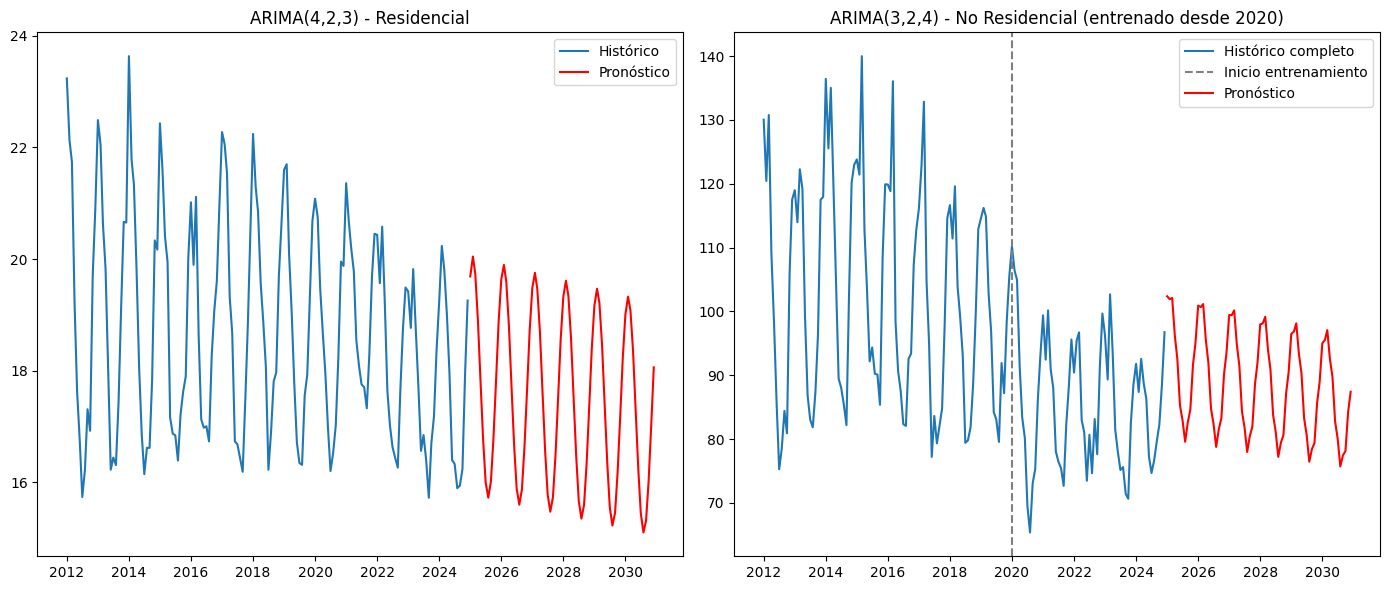

In [73]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Definir los IDs
id_residencial = "BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL;AGUAS ANDINAS;Residencial"
id_no_residencial = "BUIN - PAINE - LINDEROS - MAIPO - ALTO JAHUEL;AGUAS ANDINAS;No Residencial"

# Filtrar series completas
serie_residencial = df[df["id_combinacion"] == id_residencial]["dotacion_consumo"].sort_index()
serie_no_residencial_full = df[df["id_combinacion"] == id_no_residencial]["dotacion_consumo"].sort_index()

# Para entrenamiento de No Residencial: desde 2020
serie_no_residencial_train = serie_no_residencial_full[serie_no_residencial_full.index >= "2020-01-01"]

# Ajustar modelos ARIMA
modelo_residencial = ARIMA(serie_residencial, order=(4, 2, 3)).fit()
modelo_no_residencial = ARIMA(serie_no_residencial_train, order=(3, 2, 4)).fit()

# Pronóstico
horizonte = 72
forecast_residencial = modelo_residencial.forecast(steps=horizonte)
forecast_no_residencial = modelo_no_residencial.forecast(steps=horizonte)

# === Gráficas ===
plt.figure(figsize=(14, 6))

# Residencial
plt.subplot(1, 2, 1)
plt.plot(serie_residencial, label="Histórico")
plt.plot(forecast_residencial.index, forecast_residencial, label="Pronóstico", color="red")
plt.title("ARIMA(4,2,3) - Residencial")
plt.legend()

# No Residencial
plt.subplot(1, 2, 2)
plt.plot(serie_no_residencial_full, label="Histórico completo")
plt.axvline(pd.to_datetime("2020-01-01"), color="gray", linestyle="--", label="Inicio entrenamiento")
plt.plot(forecast_no_residencial.index, forecast_no_residencial, label="Pronóstico", color="red")
plt.title("ARIMA(3,2,4) - No Residencial (entrenado desde 2020)")
plt.legend()

plt.tight_layout()
plt.show()


#### Resultados

In [74]:
# Crear DataFrame combinado para Residencial
df_residencial_full = pd.concat([
    pd.DataFrame({
        "Fecha": serie_residencial.index,
        "dotacion_consumo": serie_residencial.values,
        "Tipo": "Histórico"
    }),
    pd.DataFrame({
        "Fecha": pd.date_range(start=serie_residencial.index[-1] + pd.DateOffset(months=1), periods=horizonte, freq="MS"),
        "dotacion_consumo": forecast_residencial.values,
        "Tipo": "Pronóstico"
    })
], ignore_index=True)

# Crear DataFrame combinado para No Residencial
df_no_residencial_full = pd.concat([
    pd.DataFrame({
        "Fecha": serie_no_residencial_full.index,
        "dotacion_consumo": serie_no_residencial_full.values,
        "Tipo": "Histórico"
    }),
    pd.DataFrame({
        "Fecha": pd.date_range(start=serie_no_residencial_full.index[-1] + pd.DateOffset(months=1), periods=horizonte, freq="MS"),
        "dotacion_consumo": forecast_no_residencial.values,
        "Tipo": "Pronóstico"
    })
], ignore_index=True)

In [75]:
df_residencial_full

Fecha  dotacion_consumo        Tipo
0   2012-01-01         23.235948   Histórico
1   2012-02-01         22.135273   Histórico
2   2012-03-01         21.742357   Histórico
3   2012-04-01         19.213446   Histórico
4   2012-05-01         17.627625   Histórico
..         ...               ...         ...
223 2030-08-01         15.102991  Pronóstico
224 2030-09-01         15.311353  Pronóstico
225 2030-10-01         16.014353  Pronóstico
226 2030-11-01         17.021254  Pronóstico
227 2030-12-01         18.060415  Pronóstico

[228 rows x 3 columns]

In [76]:
# Asegurar que 'Fecha' sea datetime y crear columna Año
df_residencial_full["Año"] = pd.to_datetime(df_residencial_full["Fecha"]).dt.year
df_no_residencial_full["Año"] = pd.to_datetime(df_no_residencial_full["Fecha"]).dt.year

# Filtrar desde 2020 en adelante
residencial_2020 = df_residencial_full[df_residencial_full["Año"] >= 2020]
no_residencial_2020 = df_no_residencial_full[df_no_residencial_full["Año"] >= 2020]

# Agrupar por año y calcular promedio
promedios_residencial = residencial_2020.groupby("Año")["dotacion_consumo"].mean()
promedios_no_residencial = no_residencial_2020.groupby("Año")["dotacion_consumo"].mean()

# Combinar en una tabla
tabla_promedios = pd.DataFrame({
    "Promedio Residencial": promedios_residencial,
    "Promedio No Residencial": promedios_no_residencial
})

In [100]:
tabla_promedios

Promedio Residencial  Promedio No Residencial
Año                                                
2020             18.562441                86.591140
2021             19.156451                86.634260
2022             18.307920                85.603366
2023             17.687289                83.744930
2024             17.854124                85.202725
2025             17.852753                91.416272
2026             17.726379                90.392373
2027             17.592920                89.368389
2028             17.459460                88.344311
2029             17.326000                87.320131
2030             17.192539                86.295843

In [96]:
# Asegurar que la columna Fecha sea tipo datetime
df_AA_BPLMA_total["Fecha"] = pd.to_datetime(df_AA_BPLMA_total["Fecha"])

# Agregar columna de año
df_AA_BPLMA_total["Año"] = df_AA_BPLMA_total["Fecha"].dt.year

# Filtrar entre 2020 y 2030
df_filtrado = df_AA_BPLMA_total[(df_AA_BPLMA_total["Año"] >= 2020) & (df_AA_BPLMA_total["Año"] <= 2030)]

# Calcular promedio anual por grupo cliente
df_promedio_anual = df_filtrado.groupby("Año")[["Residencial", "No Residencial"]].mean().reset_index()


In [ ]:
df_promedio_anual

Año   Residencial  No Residencial
0   2020  40198.000000     2433.750000
1   2021  40900.416667     2509.500000
2   2022  42201.666667     2647.916667
3   2023  44272.833333     2695.083333
4   2024  44671.166667     2671.333333
5   2025  44928.953921     2691.545307
6   2026  45072.642595     2701.892222
7   2027  45152.851664     2712.197360
8   2028  45200.662684     2722.501672
9   2029  45231.938733     2732.805159
10  2030  45254.775839     2743.107820

In [101]:
# Asegurarse de que ambas tablas estén alineadas por año
df_merged = df_promedio_anual.merge(
    tabla_promedios,
    on="Año",
    how="inner"
)

# Calcular consumo por tipo
df_merged["Consumo Residencial"] = df_merged["Residencial"] * df_merged["Promedio Residencial"]
df_merged["Consumo No Residencial"] = df_merged["No Residencial"] * df_merged["Promedio No Residencial"]

# Sumar consumo total
df_merged["Consumo Anual"] = df_merged["Consumo Residencial"] + df_merged["Consumo No Residencial"]

# Sumar clientes totales
df_merged["Clientes Totales"] = df_merged["Residencial"] + df_merged["No Residencial"]

# Crear nuevo DataFrame con dotación promedio total
df_dotacion_total = df_merged[["Año", "Consumo Anual", "Clientes Totales"]].copy()
df_dotacion_total["Dotación Promedio Total"] = df_dotacion_total["Consumo Anual"] / df_dotacion_total["Clientes Totales"]


In [104]:
df_dotacion_total = df_dotacion_total.drop(columns=["Consumo Anual"])

In [105]:
df_dotacion_total

Año  Clientes Totales  Dotación Promedio Total
0   2020      42631.750000                22.446045
1   2021      43409.916667                23.057301
2   2022      44849.583333                22.281039
3   2023      46967.916667                21.477767
4   2024      47342.500000                21.654315
5   2025      47620.499228                22.010616
6   2026      47774.534816                21.836010
7   2027      47865.049025                21.659963
8   2028      47923.164356                21.486408
9   2029      47964.743891                21.313935
10  2030      47997.883659                21.141835